# Particles

In [1]:
import json
import os
import subprocess
import glob

import numpy as np
from pathlib import Path
import yaml
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from matplotlib.ticker import MaxNLocator
import lossmaps as lm
import xobjects as xo

import xtrack as xt
import xcoll as xc

import lossmaps as lm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import xarray as xr

import json
import copy

import xtrack as xt
import xpart as xp
import xobjects as xo


import pickle 
import h5py
import io
import scipy
from scipy.optimize import curve_fit

import ast

from scipy.special import erf
import scipy.optimize as opt
from matplotlib.ticker import FixedLocator
from scipy.stats import norm

import uproot 


In [2]:
# ---------------------------- SIMULATION CHECKING FUNCTIONS ----------------------------
def ls(return_list = False, path="/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/"):
    if return_list:
        return subprocess.check_output("ls -ht " + path, shell=True).decode('ascii').strip().split('\n')
    else:
        print(subprocess.check_output("ls -ht " + path, shell=True).decode('ascii').strip())

def get_simulation_output(folder, path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/",file_name="htcondor*.out", print_1=True, n=0):
    try:
        file_content = subprocess.check_output("cat " + path + folder + f'/Job.{n}/' + file_name, shell=True).decode('ascii').strip()
    except:
        print('File not found at: ' + path + folder + f'/Job.{n}/' + file_name)
        return
    if print_1:
        print(file_content)
    else:
        return file_content

def get_analysis_init(folder, suffix='' , path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/", file_name="htcondor*.out", n=0, only_sim_obj = True):
    file_lines = get_simulation_output(folder, print_1=False, path = path, n=n).split('\n')
    if only_sim_obj:
        file_pattern = os.path.join(path, folder, 'input_cache', 'config_sim*.yaml')
        matching_files = glob.glob(file_pattern)
        if matching_files:
            with open(matching_files[0], 'r') as file:
                config = yaml.load(file, Loader=yaml.FullLoader)
                obj_list = config['run']['save_list']

    for i in range(len(file_lines)):
        if 'CrystalAnalysis' in file_lines[i] or 'TargetAnalysis' in file_lines[i]:
            if file_lines[i-1] in ['TCCS', 'TCCP', 'TARGET', 'PIXEL', 'TCP', 'BLM', 'TCLA', 'TFT']:
                if only_sim_obj:
                    if any([file_lines[i-1] in obj for obj in obj_list]):
                        print(file_lines[i-1]+suffix+' = '+file_lines[i])
                else:    
                    print(file_lines[i-1]+suffix+' = '+file_lines[i])
            else:    
                print('OBJ'+suffix+' = '+file_lines[i])



def check_config(folder, path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/", cat=['run']):
    file_pattern = os.path.join(path, folder, 'input_cache', 'config_sim*.yaml')
    matching_files = glob.glob(file_pattern)
    if matching_files:
        with open(matching_files[0], 'r') as file:
            config = yaml.load(file, Loader=yaml.FullLoader)
    for c in cat:
        print(config[c])


def check_hdf_keys(input_path):
    with pd.HDFStore(input_path, 'r') as store:
         keys = store.keys()
    for key in keys:
        print(key)


def display_rows(rows = None, cols = None):
    pd.set_option('display.max_rows', rows)
    pd.set_option('display.max_columns', cols)



In [3]:
# ----------------------------- TURN AND COMPARISON FUNCTIONS ----------------------------


def plot_at_turn(TCCS, TARGET, n_turn, plot_whole = False, plot_chann=True, percentile = 0.0):

    df_TCCS = TCCS.data
    df_TARGET = TARGET.impact_part()
    df_TARGET_all = TARGET.data

    df_TCCS = df_TCCS[df_TCCS['this_turn']==n_turn]
    df_TARGET = df_TARGET[df_TARGET['this_turn']==n_turn]
    df_TARGET_all = df_TARGET_all[df_TARGET_all['this_turn']==n_turn]

    print("IMPACT ON TCCS AT TURN ", n_turn)    
    fig_TCCS, ax_TCCS_list = TCCS.plot_distributions(df_TCCS['x'], df_TCCS['y'], df_TCCS['px'], df_TCCS['py'], xpcrit=True, return_fig=True, percentile = percentile)
    if plot_whole:
        ax_TCCS_list[1].hist(TCCS.data['y'], bins=100, alpha = 0.3) 
        ax_TCCS_list[2].scatter(TCCS.data['x'], TCCS.data['y'], alpha = 0.03, zorder=1) 
        ax_TCCS_list[4].hist(TCCS.data['py'], bins=100, alpha = 0.3) 

    print("IMPACT ON TARGET AT TURN ", n_turn)    
    fig_TARGET, ax_TARGET_list = TARGET.plot_distributions(df_TARGET['x'], df_TARGET['y'], df_TARGET['px'], df_TARGET['py'],  return_fig=True, percentile = percentile)
    if plot_whole:
        ax_TARGET_list[2].scatter(TARGET.data['x'], TARGET.data['y'], alpha = 0.03, zorder=1) 

    common_ids = np.intersect1d(df_TCCS['particle_id'], df_TARGET['particle_id'])

    channable = df_TCCS[(df_TCCS['py'] > TCCS.align_angle - np.abs(TCCS.xp_crit)) & (df_TCCS['py'] < TCCS.align_angle  + np.abs(TCCS.xp_crit))]

    print('TCCS impacts: ', len(df_TCCS), '\ninside critical angle:', len(channable)  ,'\nTARGET impacts' ,len(df_TARGET), '\nCommon impacts: ', len(common_ids))

    df_common = df_TCCS[df_TCCS['particle_id'].isin(common_ids)]
    print("\nIMPACTS ON TARGET FROM TCCS AT TURN ", n_turn)    
    fig_common, ax_common_list = TCCS.plot_distributions(df_common['x'], df_common['y'], df_common['px'], df_common['py'], xpcrit=True, return_fig=True)

    if plot_chann:
        ax_TCCS_list[2].scatter(df_common['x'], df_common['y'], color='pink',zorder=10, alpha =0.01) 
        ax_TCCS_list[4].hist(df_common['py'], bins=90, alpha = 0.3, color='pink')


def check_plot_turns(TCCS, TARGET, turns=200):
    df_TCCS = TCCS.data
    df_TARGET = TARGET.impact_part()
    tccs, target, channable, common = [], [], [], []
    x = np.arange(turns)
    for t in range(turns):
        tccs.append(len(df_TCCS[df_TCCS['this_turn']==t]))
        target.append(len(df_TARGET[df_TARGET['this_turn']==t]))
        tmp_TCCS = df_TCCS[df_TCCS['this_turn']==t]
        tmp_target = df_TARGET[df_TARGET['this_turn']==t]
        common_ids = np.intersect1d(tmp_TCCS['particle_id'], tmp_target['particle_id'])
        channable.append(len(tmp_TCCS[(tmp_TCCS['py'] > TCCS.align_angle - np.abs(TCCS.xp_crit)) & (tmp_TCCS['py'] < TCCS.align_angle  + np.abs(TCCS.xp_crit))]))
        common.append(len(tmp_TCCS[tmp_TCCS['particle_id'].isin(common_ids)]))

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(x, tccs, label='TCCS impacts')
    ax.plot(x, target, label='TARGET impacts')
    ax.plot(x, channable, label='TCCS impacts inside critical angle')
    ax.plot(x, common, label='Common impacts')
    #ax.set_yscale('log')
    ax.legend()
    print(np.argmax(target))



def plot_turn_impacts(impact_list, turns=200, threshold=10000, labels = None, linestyles = None, return_fig = False):
    if not hasattr(impact_list, '__iter__'):
            impact_list = [impact_list]
    dfs = [i.impact_part() for i in impact_list]

    x = np.arange(turns)
    fig, ax = plt.subplots(figsize=(10, 7))

    for i, df in enumerate(dfs):
        imp = []
        for t in range(turns):
            imp.append(len(df[df['this_turn']==t]))

        if labels is not None:
            label=labels[i]
        else:
             label = f'impacts {i}'
        if linestyles is not None:
            linestyle=linestyles[i]
        else:
            linestyle = '-'
        ax.plot(x, imp, label=label, linewidth=2, linestyle=linestyle, marker='o')
        peaks = []
        for i in range(1, len(imp)):
            if imp[i] - imp[i-1] > threshold:
                peaks.append(i)
        print('\nPeaks at turns: ', peaks)       
        print('Absolute max: ', np.argmax(imp))

    ax.legend()
    ax.set_xlabel('Turn number')
    ax.set_ylabel('N impacts')

    if return_fig:
        return fig, ax  

def calculate_target_impacts_threshold(TARGET, threshold , turns=200):
    df_TARGET = TARGET.impact_part()
    target = []
    x = np.arange(turns)
    for t in range(turns):
        target.append(len(df_TARGET[df_TARGET['this_turn']==t]))

    print('thershold: ', threshold, 'before thershold: ', np.sum(target[:threshold]), f"{  (np.sum(target[:threshold])/np.sum(target)*100):.{1}f}% \t after thershold: ", np.sum(target[threshold:]), f"   {(np.sum(target[threshold:])/np.sum(target)*100):.{1}f}%")

##### class

In [4]:
TCCS_name = 'tccs.5r3.b2'
TCCP_name = 'tccp.4l3.b2'
TARGET_name = 'target.4l3.b2'
PIXEL_name = 'pixel.detector'
TFT_name = 'tft.detector'
TCP_name = 'tcp.d6r7.b2'
TCLA_name = 'tcla.a5l3.b2'

names_list = [TCCS_name, TCCP_name, TARGET_name, PIXEL_name, TFT_name, TCP_name, TCLA_name]

class ParticleAnalysis():

    def __init__(self, n_sigma, length, sigma, xdim = None, ydim = None, beam = 2, plane = 'V', jaw_L = None, emittance_n = 3.5e-6):

        self.beam = beam
        self.plane = plane
        self.n_sigma = n_sigma
        self.length = length
        self.xdim = xdim
        self.ydim = ydim
        self.sigma = sigma
        if jaw_L is not None:
            self.jaw_L = jaw_L
        else:
            self.jaw_L = sigma * n_sigma
        self.p0c = None
        self.npart = None
        self.data = None
        self.gamma0 = None
        self.beta0 = None
        self.charge = None
        self.mass = None
        self.emittance_n = emittance_n
        self.emittance = None

        if xdim is not None and ydim is not None:
            if self.plane == 'H':
                self.abs_y_low = -self.ydim/2
                self.abs_y_up = self.ydim/2
                self.abs_x_low = self.jaw_L
                self.abs_x_up = self.jaw_L + self.xdim
                self.ref = self.jaw_L - self.n_sigma*self.sigma 

            elif self.plane == 'V':       
                self.abs_y_low = self.jaw_L
                self.abs_y_up = self.jaw_L + self.ydim
                self.abs_x_low = -self.xdim/2
                self.abs_x_up = self.xdim/2
                self.ref = self.jaw_L - self.n_sigma*self.sigma 
        else:
            if self.plane == 'H':
                self.abs_y_low = None
                self.abs_y_up = None
                self.abs_x_low = self.jaw_L
                self.abs_x_up = None
                self.ref = self.jaw_L - self.n_sigma*self.sigma 
            elif self.plane == 'V':       
                self.abs_y_low = self.jaw_L
                self.abs_y_up = None
                self.abs_x_low = None
                self.abs_x_up = None
                self.ref = self.jaw_L - self.n_sigma*self.sigma 

        self.fit = None

        self.n_jobs = None
        self.part_per_job = None
        
        self.lossmap = None 
        self.losses = None

        self.tw = None     
            
            
    def retreive_file_path(self, prefix_name, file_name = 'particle*.h5', path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/", Condor = True, n_return = None):
        
        if Condor:
            test_list = [path + i for i in os.listdir(path) if prefix_name in i]
            for test_name in test_list:

                n_jobs = int(subprocess.check_output("find "+ test_name +" -maxdepth 1 -mindepth 1 -type d | grep Job. | wc -l", shell=True))

                path_list =[]

                for i in range(n_jobs):
                    file_path_part = (subprocess.check_output("echo " + test_name + '/Job.' + str(i) + '/Outputdata/' + file_name, shell=True)).decode('ascii').strip()
                    if os.path.exists(file_path_part):
                        path_list.append(file_path_part)

                n_jobs_verify  = len(path_list)
                if n_jobs != n_jobs_verify:
                    print("!!! Succesful Jobs: ", n_jobs_verify, '/', n_jobs, ' in file: ', test_name)
        else:
            path_list = (subprocess.check_output("echo " + path + prefix_name +file_name, shell=True)).decode('ascii').strip()
        
        if not hasattr(path_list, '__iter__') or isinstance(path_list, str):
            path_list = [path_list]

        if n_return is not None:
            return path_list[:n_return]
        else:
            return path_list   
    


    def load_particles(self, path, df_key, Condor=True, 
                       file_name='particle*.h5', 
                       default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                       n_return = None,
                       part_per_job = 50000,
                       **kwargs):

        h5_file_path = self.retreive_file_path(prefix_name = path, file_name = file_name, path = default_path, Condor=Condor, n_return = n_return)       
        if Condor == True:
            self.part_per_job = part_per_job
            self.n_jobs = len(h5_file_path)

        df_particles = pd.DataFrame()
        npart = 0
        for file in h5_file_path:

            job_id = int(file.split('Job.')[1].split('/')[0]) if Condor else 0
            
            try:
                df_tmp = pd.read_hdf(file, key=df_key) #test_particles_B2V                  
                df_tmp['particle_id'] = df_tmp['particle_id'] + part_per_job*job_id    
                if 'at_element' in df_tmp.columns and df_tmp['at_element'].dtype == 'int32':
                    try:
                        idx_table = pd.read_hdf(file, key='idx').to_dict()[0]
                        df_tmp['at_element'] = df_tmp['at_element'].map(idx_table)
                    except:
                        pass
            
                for col in ['interactions']:
                    if col in df_tmp.columns:
                        df_tmp[col] = df_tmp[col].apply(lambda x:x.split(',') if isinstance(x, str) else x)
                
                for col in ['TCCP_turn', 'TCCS_turn', 'CRY_turn']:
                    if col in df_tmp.columns:
                        df_tmp[col] = df_tmp[col].apply(lambda x:x.split(',') if isinstance(x, str) else x)           
                        df_tmp[col] = df_tmp[col].apply(lambda x: [int(i) if i != 'None' else i for i in x] )
                        df_tmp[col] = df_tmp[col].apply(lambda x: [] if 'None' in x else x)                
                
                TCP_turns = []

                if 'TCP_turn' in df_tmp.columns:
                    for s in df_tmp['TCP_turn']:
                        TCP_turns.append(ast.literal_eval(f'[{s}]') if s != "None" else [[],[],[]]) 
                    df_tmp['TCP_turn'] = TCP_turns
                
                df_particles = pd.concat([df_particles, df_tmp])

            except FileNotFoundError:
                print(f"Error: File not found at {file}")
                continue
            except pd.errors.EmptyDataError:
                print(f"Error: The HDF5 file at {file} is empty.")
                continue
            except Exception as e:
                print(f"Error: An unexpected error occurred - {e}")
                continue
            npart = npart + len(df_tmp)

                  
        self.npart = npart

        if 'p0c' in df_particles.columns:     
            if len(df_particles['p0c'].unique()) == 1:
                p0c = df_particles['p0c'].unique()[0]
            else:
                print('There are particles at different energies')            
            self.p0c = p0c
        else:
            metadata = pd.read_hdf(h5_file_path[0], key='metadata').to_dict()[0]

            self.p0c = metadata['p0c']
            self.gamma0 = metadata['gamma0']
            self.beta0 = metadata['beta0']
            self.charge = metadata['q0']
            self.mass = metadata['mass0']
            self.emittance = self.emittance_n / (self.gamma0 * self.beta0)


        return df_particles.reset_index(drop=True)
    
    def impact_part(self):
        if self.xdim is None or self.ydim is None:
            if self.plane == 'H':
                hit_mask = self.data['x'] >= self.abs_x_low
            elif self.plane == 'V':
                hit_mask = self.data['y'] >= self.abs_y_low
        else:
            hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
        return self.data[hit_mask]   
    
    def get_job_id(self, abs_id, TCCS = None):
        
        if not hasattr(abs_id, '__iter__') or isinstance(abs_id, str):
            abs_id = [abs_id]
        elif isinstance(abs_id, pd.Series):
            abs_id = abs_id.to_list()

        for id in abs_id:
            print(f'\nabs_id: {id}')
            if TCCS is not None:
                df_tccs = TCCS.data
                df_tccs = df_tccs[df_tccs['particle_id'] == id]
                if len(df_tccs==1):
                    print('Part is in TCCS')
                    if df_tccs.py.iloc[0] > TCCS.align_angle - np.abs(TCCS.xp_crit) and df_tccs.py.iloc[0] < TCCS.align_angle + np.abs(TCCS.xp_crit):
                        print('Part in critical angle')
                    else:   
                        print('Part is NOT in critical angle')
                else:
                    print('Particle is NOT in TCCS')
               
                
            number = id/self.part_per_job
            integer_part = int(divmod(number, 1)[0])

            fractional_part = int(np.round((number % 1) * self.part_per_job))

            print('Turn of channeling: ', self.data[self.data['particle_id'] == id].this_turn.iloc[0])
            print(f"Job Number: {integer_part}, ID: {fractional_part} ")

    def hist_jobs(self):   
        jobs = divmod(self.data['particle_id']/self.part_per_job, 1)[0]
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.hist(jobs, bins=self.n_jobs)
        ax.set_xlabel('job_id')
        ax.set_ylabel('n_part')    

    def plot_rectangle(self, ax, x_low, x_up, y_low, y_up, zorder = 100, linewidth = 1, edgecolor = 'r'):
        rect = patches.Rectangle((x_low, y_low), x_up - x_low, y_up - y_low, edgecolor=edgecolor, facecolor='none', zorder=zorder, linewidth=linewidth)
        ax.add_patch(rect)


    def plot_xy_distribution(self, fig, ax, x, y, bins = 100, axins_params = ["100%", "5%", "right", -6], sigma_line = True,**kwargs):
       

        h = ax.hist2d(x, y, bins=bins, norm=matplotlib.colors.LogNorm(), zorder=2)
    
        if 'ylim' in kwargs.keys():
            ax.set_ylim(kwargs['ylim'][0], kwargs['ylim'][1])
        if 'xlim' in kwargs.keys():
            ax.set_xlim(kwargs['xlim'][0], kwargs['xlim'][1])
        if 'plot_support' in kwargs.keys() and kwargs['plot_support'] == True:
            ax.set_xlim(-12.5e-3, 12.5e-3)
            ax.set_ylim(self.abs_y_low-4e-3, self.abs_y_up+11e-3)
    

        ax.set_xlabel(r'x [mm]')
        ax.set_ylabel(r'y [mm]')
        ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e3:.{3}f}" for x_tick in ax.get_xticks()])
        ax.set_yticks(ticks=ax.get_yticks(), labels=[f"{x_tick*1e3:.{3}f}" for x_tick in ax.get_yticks()])
        

        if self.plane == 'V':

            ax_tw = ax.twinx()
            sigma_abs = self.sigma #self.jaw_L/self.n_sigma
            ax_tw.set_ylim((ax.get_ylim()[0]-self.ref)/sigma_abs, (ax.get_ylim()[1]-self.ref)/sigma_abs)
            
            if ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] < 20:
                n_ticks = 2
            elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 20 and ax_tw.get_ylim()[0] - ax_tw.get_ylim()[1] < 60:
                n_ticks = 4
            elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 60 and ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] < 100:
                n_ticks = 8
            elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 100:
                n_ticks = 16
            yticks = np.arange(np.ceil(ax_tw.get_ylim()[0]), np.floor(ax_tw.get_ylim()[1]) + 1, n_ticks)
            ax_tw.set_yticks(yticks)
            ax_tw.set_ylabel(r' n $\sigma$')
            
            if sigma_line:
                ax_tw.axhline(self.n_sigma, color = 'r', linestyle = '--')
            #go_support
            if 'plot_support' in kwargs.keys() and kwargs['plot_support'] == True:
                self.plot_rectangle(ax, self.abs_x_low, self.abs_x_up, self.abs_y_low, self.abs_y_up, zorder = 1, linewidth = 2, edgecolor = 'r')
                self.plot_rectangle(ax, self.abs_x_up, self.abs_x_up+8e-3, self.abs_y_low, self.abs_y_up, zorder = 1, linewidth = 2, edgecolor = 'blue')
                self.plot_rectangle(ax, self.abs_x_low-8e-3, self.abs_x_low, self.abs_y_low, self.abs_y_up, zorder = 1, linewidth = 2, edgecolor = 'blue')
                self.plot_rectangle(ax, self.abs_x_up, self.abs_x_up + 8e-3, self.abs_y_low, self.abs_y_low-1e-3, zorder = 1, linewidth = 2, edgecolor = 'grey')
                self.plot_rectangle(ax, self.abs_x_low-8e-3, self.abs_x_low, self.abs_y_low, self.abs_y_low-1e-3, zorder = 1, linewidth = 2, edgecolor = 'grey')
                self.plot_rectangle(ax, self.abs_x_up + 1.1e-3, self.abs_x_up + 8e-3, self.abs_y_low-1e-3, self.abs_y_low-3e-3, zorder = 1, linewidth = 2, edgecolor = 'grey')
                self.plot_rectangle(ax, self.abs_x_low-8e-3, self.abs_x_low-1.1e-3, self.abs_y_low-1e-3, self.abs_y_low-3e-3, zorder = 1, linewidth = 2, edgecolor = 'grey')
                self.plot_rectangle(ax, self.abs_x_up, self.abs_x_up + 8e-3, self.abs_y_up, self.abs_y_up+10e-3, zorder = 1, linewidth = 2, edgecolor = 'grey')
                self.plot_rectangle(ax, self.abs_x_low-8e-3, self.abs_x_low, self.abs_y_up, self.abs_y_up+10e-3, zorder = 1, linewidth = 2, edgecolor = 'grey')
                self.plot_rectangle(ax, self.abs_x_low, self.abs_x_up, self.abs_y_up+5e-3, self.abs_y_up+10e-3, zorder = 1, linewidth = 2, edgecolor = 'grey')
                #ax.axhline(self.abs_y_up + 6.5e-3, color = 'grey', linestyle = '-')
                
        elif self.plane == 'H':

            ax_tw = ax.twiny()
            sigma_abs = self.sigma #self.jaw_L/self.n_sigma
            ax_tw.set_xlim((ax.get_xlim()[0]-self.ref)/sigma_abs, (ax.get_xlim()[1]-self.ref)/sigma_abs)
            
            if ax_tw.get_xlim()[1] - ax_tw.get_xlim()[0] < 20:
                n_ticks = 2
            elif ax_tw.get_xlim()[1] - ax_tw.get_xlim()[0] > 20 and ax_tw.get_xlim()[0] - ax_tw.get_xlim()[1] < 60:
                n_ticks = 4
            elif ax_tw.get_xlim()[1] - ax_tw.get_xlim()[0] > 60 and ax_tw.get_xlim()[1] - ax_tw.get_xlim()[0] < 100:
                n_ticks = 8
            elif ax_tw.get_xlim()[1] - ax_tw.get_xlim()[0] > 100:
                n_ticks = 16
            yticks = np.arange(np.ceil(ax_tw.get_xlim()[0]), np.floor(ax_tw.get_xlim()[1]) + 1, n_ticks)
            ax_tw.set_xticks(yticks)
            ax_tw.set_xlabel(r' n $\sigma$')
            
            if sigma_line:
                ax_tw.axvline(self.n_sigma, color = 'r', linestyle = '--')

        axins = inset_axes(ax, height=axins_params[0],  width=axins_params[1], loc=axins_params[2], borderpad=axins_params[3] )
        fig.colorbar(h[3], cax=axins, orientation='vertical', label='Count (log scale)')
        ax.grid(linestyle=':')

        if 'ylim' in kwargs.keys():
            ax.set_ylim(kwargs['ylim'][0], kwargs['ylim'][1])
            ax_tw.set_ylim((kwargs['ylim'][0]-self.ref)/sigma_abs, (kwargs['ylim'][1]-self.ref)/sigma_abs)
        if 'xlim' in kwargs.keys():
            ax.set_xlim(kwargs['xlim'][0], kwargs['xlim'][1])

            


    def plot_ang_distribution(self, fig, ax, py, bins = 100, fit = None, **kwargs):
        ax.hist(py, bins=bins) 
        if self.plane == 'V':
            ax.set_xlabel(r'py [$\mu$rad]')
        elif self.plane == 'H':
            ax.set_xlabel(r'px [$\mu$rad]')
        ax.set_ylabel('')
        ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax.get_xticks()])
        if "log" in kwargs and kwargs['log'] == True: 
            ax.set_yscale("log")


    def plot_distributions_base(self, x, y, px, py, 
                                bins_x = 100, bins_y = 100, bins_px= 100, bins_py = 100,
                                fit = None, return_fig = False, **kwargs):

        if 'lines' not in kwargs:
            lines = True
        else:
            lines = kwargs['lines']

        if self.xdim is None or self.ydim is None:
            if self.plane == 'H':
                hit_mask = x >= self.abs_x_low
            elif self.plane == 'V':
                hit_mask = y >= self.abs_y_low
        else:
            hit_mask = ((x >= self.abs_x_low) & (x <= self.abs_x_up) & (y >= self.abs_y_low) & (y<= self.abs_y_up))
        
        hitting_particles = sum(hit_mask)

        if 'percentile' in kwargs.keys():
            py_min = np.percentile(py,kwargs['percentile'])
            py_max = np.percentile(py,100-kwargs['percentile'])
            pym = (py >= py_min) & (py <= py_max)
        
            px_min = np.percentile(px,kwargs['percentile'])
            px_max = np.percentile(px,100-kwargs['percentile'])
            pxm = (px >= px_min) & (px <= px_max)

            y_min = np.percentile(y,kwargs['percentile'])
            y_max = np.percentile(y,100-kwargs['percentile'])
            ym = (y >= y_min) & (y <= y_max)
         
            x_min = np.percentile(x,kwargs['percentile'])
            x_max = np.percentile(x,100-kwargs['percentile'])
            xm = (x >= x_min) & (x <= x_max)

        else:
            pym = np.ones(len(py), dtype=bool)
            pxm = np.ones(len(px), dtype=bool)
            ym = np.ones(len(y), dtype=bool)
            xm = np.ones(len(x), dtype=bool)
            
        fig1 = plt.figure(figsize=(22, 10))
        ax1 = fig1.add_subplot(2,3,1)
        ax1.hist(x[xm & ym], bins=bins_x)
        ax1.set_xlabel('x [mm]')
        ax1.set_ylabel("")
        if lines:
            ax1.axvline(self.abs_x_low, color = 'r', linestyle = '--')
            ax1.axvline(self.abs_x_up, color = 'r', linestyle = '--')
        ax1.set_xticks(ticks=ax1.get_xticks(), labels=[f"{x_tick*1e3:.{2}f}" for x_tick in ax1.get_xticks()])

        ax2 = fig1.add_subplot(2,3,2)
        ax2.hist(y[xm & ym], bins=bins_y) 
        ax2.set_xlabel('y [mm]')
        if lines:
            ax2.axvline(self.abs_y_low, color = 'r', linestyle = '--')
            ax2.axvline(self.abs_y_up, color = 'r', linestyle = '--')
        ax2.set_ylabel('')
        
        ax2.set_xticks(ticks=ax2.get_xticks(), labels=[f"{x_tick*1e3:.{2}f}" for x_tick in ax2.get_xticks()])
        ax2.set_title(f'Total particles: {len(x)},      Hitting particles: {hitting_particles}')

        ax3 = fig1.add_subplot(2,3,3)

        ax12 = fig1.add_subplot(2,3,4)
        ax22 = fig1.add_subplot(2,3,5)

        if self.plane == 'V':
        
            ax12.hist(px[pxm & pym & hit_mask], bins=bins_px)
            ax12.set_xlabel(r'px [$\mu$rad]')
            ax12.set_ylabel("")        
            ax12.set_xticks(ticks=ax12.get_xticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax12.get_xticks()])
      
            self.plot_ang_distribution(fig1, ax22, py[pym & pxm & hit_mask], bins = bins_py, **kwargs)

        elif self.plane == 'H':

            self.plot_ang_distribution(fig1, ax12, px[pym & pxm & hit_mask], bins = bins_px, **kwargs)
            
            ax22.hist(py[pxm & pym & hit_mask], bins=bins_py)
            ax22.set_xlabel(r'py [$\mu$rad]')
            ax22.set_ylabel("")        
            ax22.set_xticks(ticks=ax22.get_xticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax22.get_xticks()])
      
   


        ax32 = fig1.add_subplot(2,3,6)
        h2 = ax32.hist2d(px[hit_mask], py[hit_mask], bins=(bins_px, bins_py), norm=matplotlib.colors.LogNorm(), zorder=2)  #,, norm=matplotlib.colors.LogNorm() range = ([-40e-6, 40e-6], [-40e-6,40e-6])
        ax32.set_xlabel(r'px [$\mu$rad]')
        ax32.set_ylabel(r'py [$\mu$rad]')
        ax32.set_xticks(ticks=ax32.get_xticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax32.get_xticks()])
        ax32.set_yticks(ticks=ax32.get_yticks(), labels=[f"{x_tick*1e6:.{1}f}" for x_tick in ax32.get_yticks()])
        if len(px[hit_mask]) > 0:
            axins_2 = inset_axes(ax32, height="100%",  width="5%", loc='right', borderpad=-6 )
            fig1.colorbar(h2[3], cax=axins_2, orientation='vertical', label='Count (log scale)')
        ax32.grid(linestyle=':')

        if "log" in kwargs and kwargs['log'] == True:  
            ax22.set_yscale("log")
            ax2.set_yscale("log")
            ax12.set_yscale("log")
            ax1.set_yscale("log")

        if fit is not None:
           
            def gaussian(x, A, mu, sigma):
                return A * np.exp(-(x - mu)**2 / (2 * sigma**2))
            
            for ax, val in zip([ax1, ax2, ax12, ax22], ['x', 'y', 'px', 'py']):
                xmin, xmax = ax.get_xlim()
                x = np.linspace(xmin, xmax, 100)


                hist_values = [rect.get_height() for rect in ax.patches]
                bin_edges = [rect.get_x() for rect in ax.patches]

                # Calculate the area of the histogram
                bin_widths = np.diff(bin_edges)  
                bin_widths = np.append(bin_widths, 0) 
                hist_area = np.sum(hist_values * bin_widths)  

                tmp_y = gaussian(x, fit.loc[val, 'A'], fit.loc[val, 'mu'], fit.loc[val, 'sigma'])
                funct_area = np.trapz(tmp_y, x=x)

                ax.plot(x, gaussian(x, fit.loc[val, 'A']/funct_area*hist_area, fit.loc[val, 'mu'], fit.loc[val, 'sigma']), 'g', linestyle = '-', linewidth=1)


            ellipse_x= patches.Ellipse((fit.loc['x', 'mu'], fit.loc['y', 'mu']), width=3*fit.loc['x', 'sigma'], height=3*fit.loc['y', 'sigma'],fill=False, color = 'g')
            ax3.add_patch(ellipse_x)    
            ax3.set_aspect('equal')

            ellipse_p= patches.Ellipse((fit.loc['px', 'mu'], fit.loc['py', 'mu']), width=3*fit.loc['px', 'sigma'], height=3*fit.loc['py', 'sigma'],fill=False, color = 'g')
            ax32.add_patch(ellipse_p)    
            ax32.set_aspect('equal')

        if return_fig:
            return fig1, [ax1, ax2, ax3, ax12, ax22, ax32]  
        else:
            plt.show()
        
        
    def fit_gaussian(self, impacts = None, plot = True):

        if impacts is None:
            impacts = self.impact_part
            
        def gaussian(x, A, mu, sigma):
            return A * np.exp(-(x - mu)**2 / (2 * sigma**2))
        

        def fit(data, ax = None, plot = True):

            hist, bins = np.histogram(data, bins=100)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            initial_guess = [np.max(hist), np.mean(data), np.std(data)]
            popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=initial_guess)

            if plot:
                ax.bar(bin_centers, hist, width=np.diff(bins), edgecolor='k', align='center', label='Histogram')
                x_fit = np.linspace(min(bin_centers), max(bin_centers), 100)
                ax.plot(x_fit, gaussian(x_fit, *popt), 'r-', label='Gaussian fit')
            return popt

        if plot:
            fig1 = plt.figure(figsize=(15, 8))
        df_gauss = pd.DataFrame(columns=[ 'mu', 'sigma'])
        for idx, val in enumerate(['x', 'y', 'px', 'py']):
            ax = None
            if plot:
                ax = fig1.add_subplot(2, 2, idx+1)            
            popt = fit(impacts[val], ax, plot = plot)
            df_gauss = pd.concat([df_gauss, pd.DataFrame({'A':[popt[0]] , 'mu': [popt[1]], 'sigma': [popt[2]]}, index=[val])])
            if plot:
                ax.set_xlabel(val)
                ax.legend()
            
        self.fit = df_gauss


    # BBBBBB
    def compute_impact_particles(self, sigma = False, log=False, xpcrit= False, fit = False, return_fig = False, bins = 200, **kwargs):
        if self.data is None:
            self.load_particles(kwargs['h5_file_path'])
      
        fit_param = None
        if fit:
            if self.fit is None:
                self.fit_gaussian(plot=False)
            fit_param = self.fit
        if return_fig:
            return self.plot_distributions(self.data['x'], self.data['y'], self.data['px'], self.data['py'], return_fig = return_fig ,  sigma=sigma, log=log, xpcrit=xpcrit, fit = fit_param, bins = bins, **kwargs)
        else:
            self.plot_distributions(self.data['x'], self.data['y'], self.data['px'], self.data['py'], sigma=sigma, log=log, xpcrit=xpcrit, fit = fit_param, bins = bins, **kwargs)

    def plot_phasespace(self, impacts = False, **kwargs):

        fig1 = plt.figure(figsize=(18, 5))
        ax1 = fig1.add_subplot(1,2,1)
        ax2 = fig1.add_subplot(1,2,2)

        
        if impacts:
            px, py, x, y = self.impact_part()['px'], self.impact_part()['py'], self.impact_part()['x'], self.impact_part()['y']
        else:
            px, py, x, y  = self.data['px'], self.data['py'], self.data['x'], self.data['y']
        #ax1.scatter(self.data['x'], self.data['px'])
        #ax2.scatter(self.data['y'], self.data['py'])
        h1 = ax1.hist2d(x, px, bins=100, norm=matplotlib.colors.LogNorm())#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax1.set_xlabel(r'x [m]')
        ax1.set_ylabel(r'px [rad]')
        axins = inset_axes(ax1, height="100%",  width="5%", loc='right', borderpad=-3)
        fig1.colorbar(h1[3], cax=axins, orientation='vertical')
        ax1.grid(linestyle=':')
        #ax1.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        #ax1.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.yticks()[0]])


        h2 = ax2.hist2d(y,py, bins=100, norm=matplotlib.colors.LogNorm())#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax2.set_xlabel(r'y[m]')
        ax2.set_ylabel(r'py [rad]')

        if self.plane == 'V':
            ax2.axvline(self.jaw_L, color = 'r', linestyle = '-')
            if hasattr(self, 'align_angle'):
                ax2.axhline(self.align_angle, color = 'r', linestyle = '-')
                ax2.axhline(self.align_angle - np.abs(self.xp_crit), color = 'r', linestyle = '--')
                ax2.axhline(self.align_angle + np.abs(self.xp_crit), color = 'r', linestyle = '--')
        elif self.plane == 'H':
            ax1.axvline(self.jaw_L, color = 'r', linestyle = '-')
            if hasattr(self, 'align_angle'):
                ax1.axhline(self.align_angle, color = 'r', linestyle = '-')
                ax1.axhline(self.align_angle - np.abs(self.xp_crit), color = 'r', linestyle = '--')
                ax1.axhline(self.align_angle + np.abs(self.xp_crit), color = 'r', linestyle = '--')

        axins2 = inset_axes(ax2, height="100%",  width="5%", loc='right', borderpad=-6 )
        fig1.colorbar(h2[3], cax=axins2, orientation='vertical', label='Count (log scale)')
        ax2.grid(linestyle=':')
        #ax2.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        #ax2.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.yticks()[0]])
        
        
    
    def load_lossmap(self, path, Condor = True, file_name='lossmap*', plot = True, layout = "./input_files/2023_Run3_flat_top/layout_flat_top_b2.tfs", zoom = True, outfile = None):     
        if Condor == True:
            path = self.retreive_file_path(path, file_name=file_name)     
        self.lossmap = lm.SimulatedLossMap(lmtype=lm.LMType[f'B{self.beam}{self.plane}'], machine=lm.Machine.LHC)
        self.lossmap.load_data_json(json_files=path)
        self.losses = self.lossmap._losses
        if plot:    
            lm.plot_lossmap(self.lossmap, show_zoom = zoom,  outfile = outfile)

    def plot_lossmap(self, zoom = None, layout = "./input_files/2023_Run3_flat_top/layout_flat_top_b2.tfs", outfile = None):

        if zoom == 'IR7':
            lm.plot_lossmap(self.lossmap, show_zoom = True,   outfile = outfile)
        elif zoom == 'IR3':
            lm.plot_lossmap(self.lossmap, zoom_range = [6000,7200],  outfile = outfile)
        else:
            lm.plot_lossmap(self.lossmap, show_zoom = False,   outfile = outfile)
            
    def compute_losses(self, path=None, ):
        if self.lossmap is None:
            self.load_lossmap(path)
        df = self.lossmap._losses
        names = ['tcp.d6r7.b2', 'tcp.c6r7.b2', 'tcp.b6r7.b2', 'tcla.a5l3.b2',  'tccp.4l3.b2', 'tccs.5r3.b2']
        df_losses = pd.concat([df.query('name in @names'),df[df.losses_N > np.mean(df.losses_N)]]).drop_duplicates(keep='first', subset=df.columns)
        self.losses = pd.merge(df_losses, self.lossmap.inefficiency()[['losses', 's']], on = 's').drop('losses_dE', axis = 1).sort_values(by='s', ascending=True)
        return self.losses

    def save_particle_data(self,  file_name = None, output_path='./', key = 'particles'):
        if file_name is None:
            file_name = f'particles_B{self.beam}{self.plane}.h5'    
        self.data.to_hdf(output_path + file_name, key = key, mode='w', format='table', complevel=9, complib='blosc')

    def count_interactions(self):
        if 'interactions' in self.data.columns:
            data = self.data['interactions'].apply(lambda x: str(x))
            data = data.groupby(data).count()
            pd.set_option('display.max_rows', None)
            pd.set_option('display.max_columns', None)
            print(data)
            if 'nan' in data.index:
                data = data.drop('nan')
            pd.set_option('display.max_rows', 30)
            pd.set_option('display.max_columns', 30)
            print(f"\n ---- Total interacting particles: {data.sum()} ---- \n")
        else:
            print('No interaction data available')


    def twiss_TWOCRYST(self, config_file = None, line_file= None, return_twiss = False, **kwargs):

        if config_file is not None: 
            with open(config_file, 'r') as stream:
                config_dict = yaml.safe_load(stream)   
            line_file = os.path.expandvars(config_dict['input_files']['line_b2'])
        line = xt.Line.from_json(line_file)

        part_energy = None if config_dict['run']['energy'] == 'None' else float(config_dict['run']['energy'])
        if part_energy is not None:
            line.particle_ref = xt.Particles(p0c=part_energy, #eV
                                    q0=1, mass0=xt.PROTON_MASS_EV)

        end_s = line.get_length()

        TCCS_loc_abs  = 6773.9428 
        TCCP_loc_abs  = 6653.2543  
        PIX1_loc_abs = 6652.7039
        PIX2_loc_abs = 6652.6929
        PIX3_loc_abs = 6652.6819
        TFT_loc_abs = 6652.114

        TCCS_loc = end_s - TCCS_loc_abs
        TCCP_loc = end_s - TCCP_loc_abs
        TARGET_loc = end_s - (TCCP_loc_abs + 0.070/2 +  0.005/2)
        PIX1_loc = end_s - PIX1_loc_abs
        PIX2_loc = end_s - PIX2_loc_abs
        PIX3_loc = end_s - PIX3_loc_abs
        TFT_loc = end_s - TFT_loc_abs
        TCP_loc = line.get_s_position()[line.element_names.index(TCP_name)]
        TCLA_loc = line.get_s_position()[line.element_names.index(TCLA_name)]


        line.insert_element(at_s=TCCS_loc, element=xt.Marker(), name=TCCS_name)
        line.insert_element(at_s=TCCS_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCS_name+'_aper')
        line.insert_element(at_s=TCCP_loc, element=xt.Marker(), name=TCCP_name)
        line.insert_element(at_s=TCCP_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCP_name+'_aper')
        line.insert_element(at_s=TARGET_loc, element=xt.Marker(), name=TARGET_name)
        line.insert_element(at_s=TARGET_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= TARGET_name + '_aper')
        line.insert_element(at_s=PIX1_loc, element=xt.Marker(), name=PIXEL_name+'_1')
        line.insert_element(at_s=PIX1_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= PIXEL_name+'_1' + '_aper')
        line.insert_element(at_s=PIX2_loc, element=xt.Marker(), name=PIXEL_name+'_2')
        line.insert_element(at_s=PIX2_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= PIXEL_name+'_2' + '_aper')
        line.insert_element(at_s=PIX3_loc, element=xt.Marker(), name=PIXEL_name+'_3')
        line.insert_element(at_s=PIX3_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= PIXEL_name+'_3' + '_aper')
        line.insert_element(at_s=TFT_loc, element=xt.Marker(), name=TFT_name)

        line.build_tracker()
        line.collimators.assign_optics()
        tw = line.twiss().to_pandas()[['name','s', 'x', 'y', 'betx', 'bety', 'alfx', 'alfy', 'mux', 'muy', ]]
        tw = tw[tw['name'].isin(names_list)]
        display(tw)

        self.tw = tw

        return tw if return_twiss else None


# ---------------------------------------------------  CRYSTAL   ---------------------------------------------------



class CrystalAnalysis(ParticleAnalysis):

  def __init__(self, n_sigma, length, xdim, ydim, sigma, jaw_L = None,  bending_radius=None, align_angle = None,
                beam = 2, plane = 'V',
                pot_crit = 21.34, #16 #eV Silicon
                en_crit = 5.7e9 / 1e-2, #eV/m Silicon    #dp_Si = 1.92e-10 #m
                eta = 0.9,
                xp_version = 'code',
                miscut = 0.0, **kwargs
                ):

    super().__init__(n_sigma = n_sigma, length = length, xdim = xdim, ydim = ydim, beam = beam, plane = plane, sigma = sigma, jaw_L = jaw_L)

    self.miscut = miscut
    self.align_angle = align_angle + self.miscut
    self.en_crit = en_crit
    self.pot_crit = pot_crit
    self.bending_radius = bending_radius 
    self.eta = eta
    self.xp_version = xp_version
    self.n_CRY_absorbed = None
    self.n_TCCS_absorbed = None
    self.n_TCCP_absorbed = None
    self.TCCS_sim_chann_eff = None
    self.TCCP_sim_chann_eff = None


  def load_particles(self, path, df_key = None, Condor=True, 
                      file_name='particle*.h5', 
                      default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                      n_return = None,
                      part_per_job = 50000,
                      get_absorbed = 'all'): #all, only, not

    if get_absorbed in ['all', 'not']:
        if df_key is not None:
            self.data = super().load_particles(path, df_key, Condor, file_name, default_path, part_per_job = part_per_job, n_return = n_return)
            if 'TCP_turn' in self.data.columns:   
                self.data = self.data[ ['particle_id', 'x', 'px', 'y', 'py', 'delta','zeta',  'this_turn', 'interactions', 'at_element',  'at_turn','TCCS_turn', 'TCCP_turn', 'TCP_turn'] ]
            
    if get_absorbed in ['all', 'only']:
        h5_file_path = self.retreive_file_path(prefix_name = path, file_name = file_name, path = default_path, Condor=Condor, n_return = n_return) 
        n_absorbed_CRY  = 0
        n_absorbed_TCCS = 0
        n_absorbed_TCCP = 0
        TCCS_sim_chann_eff = 0
        TCCP_sim_chann_eff = 0
        for file in h5_file_path:
            try:
                metadata = pd.read_hdf(file, key='metadata').to_dict()[0]
                if 'CRY_absorbed' in metadata.keys():
                    n_absorbed_CRY = n_absorbed_CRY + metadata['CRY_absorbed']
                if 'TCCS_absorbed' in metadata.keys():
                    n_absorbed_TCCS = n_absorbed_TCCS + metadata['TCCS_absorbed']
                if 'TCCP_absorbed' in metadata.keys():
                    n_absorbed_TCCP = n_absorbed_TCCP  + metadata['TCCP_absorbed']
                if 'TCCS_sim_chann_eff' in metadata.keys():
                    TCCS_sim_chann_eff = TCCS_sim_chann_eff + metadata['TCCS_sim_chann_eff']
                if 'TCCP_sim_chann_eff' in metadata.keys():
                    TCCP_sim_chann_eff = TCCP_sim_chann_eff + metadata['TCCP_sim_chann_eff']
            except:
                print(f"Error reading metadata from {file}")

        if df_key is None:
            self.part_per_job = part_per_job
            self.n_jobs = len(h5_file_path)
        
        self.n_CRY_absorbed = int(n_absorbed_CRY) if 'CRY_absorbed' in metadata.keys() else None 
        self.n_TCCS_absorbed = int(n_absorbed_TCCS) if 'TCCS_absorbed' in metadata.keys() else None
        self.n_TCCP_absorbed = int(n_absorbed_TCCP) if 'TCCP_absorbed' in metadata.keys() else None
        self.p0c = metadata['p0c']
        self.TCCS_sim_chann_eff = TCCS_sim_chann_eff/self.n_jobs if self.n_jobs is not None else TCCS_sim_chann_eff
        self.TCCP_sim_chann_eff = TCCP_sim_chann_eff/self.n_jobs if self.n_jobs is not None else TCCP_sim_chann_eff

    if self.xp_version == 'book': 
        xp_crit0 = np.sqrt(2.0*self.pot_crit/self.p0c)
        Rcrit = self.p0c/self.en_crit
        self.xp_crit = xp_crit0*(1-Rcrit/self.bending_radius)

    elif self.xp_version == 'manual':
        dp = 1.92e-10 
        aTF = 0.194e-10
        uT = 0.075e-10
        xc = dp/2 -0.6565*uT
        eta = (xc*2/dp)**2
        Rcrit = self.p0c/(2*eta*self.pot_crit) * xc
        self.xp_crit = np.sqrt(2*eta*self.pot_crit/self.p0c)*(1 - Rcrit/self.bending_radius)

    elif self.xp_version == 'code':
        dp = 1.92e-10 
        Rcrit = self.p0c/(2*np.sqrt(self.eta)*self.pot_crit) * (dp/2)
        self.xp_crit = np.sqrt(2*self.eta*self.pot_crit/self.p0c)*(1 - Rcrit/self.bending_radius)
    
    
    if(self.xp_crit < 0):
          print("!!!!!!!!!!!!! \nERROR: particles at",self.p0c, f"eV cannot be channeled if bending is {self.bending_radius} m \n!!!!!!!!!!!!!")


    

  def plot_ang_distribution(self, fig, ax, py, print_label=True, **kwargs):

        
        super().plot_ang_distribution(fig, ax, py, **kwargs)


        if "xpcrit" in kwargs and kwargs['xpcrit'] == True:   
            new_align_angle = None
            if "align_angle" in kwargs:
                new_align_angle = kwargs['align_angle']
            elif self.align_angle is not None:
                new_align_angle = self.align_angle
             
            if new_align_angle is not None: 
                ax.axvline(new_align_angle, color = 'red', linestyle = '-', alpha = 0.8)
                if(self.xp_crit < 0):
                    print(f"!!!!!!!!!!!!! \nERROR: particles at {self.p0c} cannot be channeled if bending is {self.bending_radius} \n!!!!!!!!!!!!!")
                else:
                    ax.axvline(new_align_angle  + np.abs(self.xp_crit), color = 'red', linestyle = '--', alpha = 0.9)
                    ax.axvline(new_align_angle - np.abs(self.xp_crit), color = 'red', linestyle = '--', alpha = 0.9)
                    chann_mask = (py > new_align_angle  - np.abs(self.xp_crit)) & (py < new_align_angle  + np.abs(self.xp_crit))
                    chann = len(py[chann_mask])
                    if print_label:
                        ax.set_title(f'N particle inside critical angle range: {chann}')



  
  def plot_distributions(self, x, y, px, py, bins = 100, fit = None, return_fig = False, **kwargs):


        if 'lines' not in kwargs:
            lines = True
        else:
            lines = kwargs['lines']
        
        # ax_list = [ax1, ax2, ax3, ax12, ax22, ax32]
        fig, ax_list = super().plot_distributions_base(x, y, px, py, fit = fit, bin_x=bins, bins_y = bins, bins_px=bins, bins_py=bins, return_fig = True, **kwargs)

        super().plot_xy_distribution(fig, ax_list[2], x, y, bins = bins,  **kwargs) #xlim = [-12.5e-3, 12.5e-3],

        if lines:
            self.plot_rectangle(ax_list[2], self.abs_x_low, self.abs_x_up, self.abs_y_low, self.abs_y_up)
        
        if return_fig:
            return fig, ax_list
        elif 'return_xy'in kwargs and kwargs['return_xy']:
            return ax_list[2]
        else:
            plt.show()


  def inside_xp_crit(self, half = False):
    impacts = self.impact_part()
    f = 0.5 if half else 1
    return impacts[(impacts['py'] > self.align_angle - f*np.abs(self.xp_crit)) & (impacts['py'] < self.align_angle  + f*np.abs(self.xp_crit))]

  def compute_channeled_part(self, impacts):

    channable_ids = self.data[(self.data['py'] > self.align_angle - np.abs(self.xp_crit)) & (self.data['py'] < self.align_angle  + np.abs(self.xp_crit))]['particle_id']
    chann_num = len(np.intersect1d(channable_ids, impacts['particle_id']))
    print('n particles that hit TCCP inside critical angle range: \t', chann_num)
    print('n part inside critical angle range: \t\t\t', len(channable_ids), f'\t\t{chann_num/len(channable_ids)*100:.2f}%' )
    print('n part that hit TCCS (multiple):\t\t\t', len(self.impact_part()), f'\t{chann_num/len(self.impact_part())*100:.2f}%')
    print('n part that hit TCCP: \t\t\t\t\t', len(impacts), f'\t\t{chann_num/len(impacts)*100:.2f}%' )
    if self.n_jobs is not None:
        print(f'total n particle in simulation: \t\t\t {self.n_jobs*self.part_per_job:.1e}\t{chann_num/(self.n_jobs*self.part_per_job)*100:.2f}%')


  def optimize_alignment(self, plot = True, return_fig = False):

    if self.plane == 'V':
        p = 'py'
    elif self.plane == 'H':
        p = 'px'
    hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
    data = self.data[[p, 'at_element']][hit_mask]
    min_p = data[p].min()
    max_p = data[p].max()
    
    n_steps = 1000
    x = np.linspace(min_p + self.xp_crit, max_p - self.xp_crit, n_steps)
    y = []
    for i in range(n_steps):
        mask = (data[p] > x[i] - self.xp_crit) & (data[p] < x[i] + self.xp_crit)
        y.append(len(data[p][mask]))

    best_angle = x[y.index(max(y))]

    if plot:
        fig1 = plt.figure(figsize=(15, 5))
        ax1 = fig1.add_subplot(1,2,1)
        ax1.plot(x, y)
        ax1.set_xlabel('angle [rad]')
        ax1.set_ylabel("n_part")
        ax1.axvline(best_angle, color = 'g', linestyle = '-')
        ax1.axvline(self.align_angle, color = 'r', linestyle = '-')

        ax2 = fig1.add_subplot(1,2,2)
        self.plot_ang_distribution(fig1, ax2, data[p], xpcrit=True, align_angle = best_angle, print=False)

        chann_mask = (data[p] > self.align_angle  - np.abs(self.xp_crit)) & (data[p] < self.align_angle  + np.abs(self.xp_crit))
        chann = len(data[p][chann_mask])

        fig1.suptitle(f'Optimal angle {best_angle:.3e},  {max(y)} particles \nAlignment angle {self.align_angle:.3e}, {chann} particles')

        if return_fig:
            return fig1, [ax1, ax2] 

    print(f'Delta angle {best_angle - self.align_angle}')



  def align_TCCS(self):

        best_jawL = min( self.data['y'])

        new_sigma = best_jawL/self.jaw_L*self.n_sigma
        self.abs_y_low = best_jawL
        self.abs_y_up = best_jawL + self.ydim
        self.n_sigma = new_sigma
        self.jaw_L = best_jawL
        #
        # hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
        #self.impact_part = self.data[hit_mask]


  def channeling_efficiency_sim(self, half = False):
        if 'interactions' in self.data.columns:
            in_xp_crit = self.inside_xp_crit(half)
            eff_sim = len(in_xp_crit[in_xp_crit.interactions.apply(lambda x: x == ['CH'])]) / len(in_xp_crit)
            print(f'Channeling efficiency: {eff_sim:.2f}')
        else:
            print('No interaction data available --  get through TCCS_sim_chann_eff and TCCP_sim_chann_eff')



# ---------------------------------------------------  TARGET   ---------------------------------------------------
    

class TargetAnalysis(ParticleAnalysis):

  def __init__(self, target_type, n_sigma,  sigma, xdim = None, ydim = None, length = None, beam = 2, plane = 'V', jaw_L = None, PIX_y_distance_to_RPX = 4.26e-3, RPX_bottom_wall_thickess = 2.14e-3):

    super().__init__(n_sigma = n_sigma, length = length, xdim = xdim, ydim = ydim, sigma = sigma, beam = beam, plane = plane, jaw_L = jaw_L)
    
    if target_type not in ['pixel', 'alfa', 'target', 'collimator']:
        print('Target type not valid\nAllowed types: [pixel, alfa, target, collimator]')
    self.type = target_type

    self.PIX_y_distance_to_RPX = PIX_y_distance_to_RPX
    self.RPX_bottom_wall_thickess = RPX_bottom_wall_thickess

    if self.type == 'pixel' and self.PIX_y_distance_to_RPX is not None:
        self.abs_y_up = self.abs_y_up + self.PIX_y_distance_to_RPX
        self.abs_y_low = self.abs_y_low + self.PIX_y_distance_to_RPX

    if self.type == 'alfa' and self.RPX_bottom_wall_thickess is not None:
        self.abs_y_up = self.abs_y_up + self.RPX_bottom_wall_thickess
        self.abs_y_low = self.abs_y_low + self.RPX_bottom_wall_thickess

    self.LSdata = None

  def load_particles(self, path, df_key = 'particles', Condor=True, 
                      file_name='particle*.h5', 
                      default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                      n_return = None,
                      part_per_job = 50000):
        
    self.data = super().load_particles(path, df_key, Condor, file_name, default_path, part_per_job = part_per_job, n_return = n_return)  
    if 'TCP_turn' in self.data.columns:
        self.data = self.data[ ['particle_id','x', 'px', 'y', 'py', 'delta','zeta',  'this_turn', 'at_element',  'at_turn','TCCS_turn', 'TCCP_turn', 'TCP_turn'] ]
    
           

    data = self.data['particle_id']
    duplicated_mask = data.duplicated()
    if len(data[duplicated_mask]) != 0:
        print(f'There are repeated particle ids!') #: {data[duplicated_mask]}')

  # AAAAAA
  def plot_distributions(self, x, y, px, py, fit = None, return_fig = False, bins = 200, **kwargs):

        if 'lines' not in kwargs:
            lines = True
        else:
            lines = kwargs['lines']

        if self.type == 'collimator':
            lines = False

        # ax_list = [ax1, ax2, ax3, ax12, ax22, ax32]
        fig, ax_list = super().plot_distributions_base(x, y, px, py, fit = fit, return_fig = True, lines = lines, bins_x=bins, bins_y = bins, bins_px=bins, bins_py=bins, **kwargs)

        if self.type == 'alfa':
            angles = [180-135, 90, 90, 90,135] 
            side_lengths = [31.1e-3, 10e-3, 32e-3, 32e-3, 10e-3]  
            angles = np.radians(angles)

            ALFA_x = [0]
            ALFA_y = [0]
            for i in range(len(side_lengths)):
                angle_sum = np.sum(angles[:i])
                ALFA_x.append(ALFA_x[-1] + side_lengths[i] * np.cos(angle_sum))
                ALFA_y.append(ALFA_y[-1] + side_lengths[i] * np.sin(angle_sum))
            # Close the pentagon by appending the first vertex at the end
            ALFA_x.append(ALFA_x[0])
            ALFA_y.append(ALFA_y[0])

            # Center in x an apply vertical offset
            y_lim = self.abs_y_low
            ALFA_x = [i -side_lengths[0]/2 for i in ALFA_x]
            ALFA_y = [i + y_lim for i in ALFA_y]

            
            super().plot_xy_distribution(fig, ax_list[2], x, y,  xlim = [np.min(ALFA_x)-1e-3, np.max(ALFA_x)+1e-3], ylim = [self.jaw_L-3.5e-3, np.max(ALFA_y)+1e-3], bins = (round(self.xdim /30e-6), round(self.ydim /30e-6)), **kwargs)
            
            if lines:
                ax_list[2].plot(ALFA_x, ALFA_y, 'r')
                #super().plot_rectangle(ax_list[2], self.abs_x_low, self.abs_x_up, self.jaw_L, self.jaw_L + self.RPX_bottom_wall_thickess)
                ax_list[2].axhline(self.jaw_L, color = 'grey', linestyle = '-')
                ax_list[2].axhline(self.jaw_L +self.RPX_bottom_wall_thickess, color = 'grey', linestyle = '-')
        
        elif self.type == 'pixel':
            super().plot_xy_distribution(fig, ax_list[2], x, y, xlim = [self.abs_x_low-1e-3, self.abs_x_up+1e-3],  ylim = [self.jaw_L-3.5e-3, self.abs_y_up+1e-3], bins = (round(self.xdim /55e-6), round(self.ydim /55e-6)), **kwargs)            
            if lines:
                if self.xdim/self.ydim == 3:
                    super().plot_rectangle(ax_list[2], self.abs_x_low, self.abs_x_low + self.xdim/3, self.abs_y_low, self.abs_y_up)
                    super().plot_rectangle(ax_list[2], self.abs_x_low + self.xdim/3, self.abs_x_low + self.xdim/3*2, self.abs_y_low, self.abs_y_up)
                    super().plot_rectangle(ax_list[2], self.abs_x_low + self.xdim/3*2, self.abs_x_up, self.abs_y_low, self.abs_y_up)
                else:
                    super().plot_rectangle(ax_list[2], self.abs_x_low, self.abs_x_up, self.abs_y_low, self.abs_y_up)
                #super().plot_rectangle(ax_list[2], self.abs_x_low, self.abs_x_up, self.jaw_L, self.jaw_L + self.RPX_bottom_wall_thickess)
                ax_list[2].axhline(self.jaw_L, color = 'grey', linestyle = '-')
                ax_list[2].axhline(self.jaw_L + self.RPX_bottom_wall_thickess, color = 'grey', linestyle = '-')
        
        elif self.type == 'target':
            super().plot_xy_distribution(fig, ax_list[2], x, y, xlim = [self.abs_x_low-1e-3, self.abs_x_up+1e-3], lines = lines, bins = bins, **kwargs) 
            if lines:
                super().plot_rectangle(ax_list[2], self.abs_x_low, self.abs_x_up, self.abs_y_low, self.abs_y_up)
        elif self.type == 'collimator':
            super().plot_xy_distribution(fig, ax_list[2], x, y, lines = lines, bins = bins, **kwargs) 
            if self.plane == 'V':
                ax_list[1].axvline(self.jaw_L, color = 'r', linestyle = '-')
            elif self.plane == 'H':
                ax_list[0].axvline(self.jaw_L, color = 'r', linestyle = '-')

        if return_fig:
            return fig, ax_list
        else:
            plt.show()

  def optimize_POT(self, set = False, mode='fit', plot = True, **kwargs):
    
        
        x = self.data['x']
        y = self.data['y']

        abs_x_low = -self.xdim/2
        abs_x_up = self.xdim/2

        nsteps = 100
        steps = np.linspace(self.jaw_L - 3e-3, self.jaw_L + self.ydim, nsteps)
        n_part = []

        for stp in steps:
            abs_y_low = stp
            abs_y_up = stp + self.ydim
            n_part.append(len(x[(x >= abs_x_low) & (x <= abs_x_up) & (y >= abs_y_low) & (y <= abs_y_up)]))
        

        if mode == 'fit':
            if self.fit is None:
                self.fit_gaussian(plot=False)

            best_jawL = self.fit.loc['y', 'mu'] - self.ydim/2
        elif mode == 'max':
            best_jawL = steps[n_part.index(max(n_part))]

        if plot:
            fig1 = plt.figure(figsize=(16, 5))
            ax1 = fig1.add_subplot(1,2,1)
            ax1.plot(steps, n_part)
            ax1.set_xlabel('y position [mm]')
            ax1.set_ylabel("n_part")
            ax1.axvline(best_jawL, color = 'g', linestyle = '-')
            ax1.axvline(self.jaw_L, color = 'r', linestyle = '-')

            ax3 = fig1.add_subplot(1,2,2)
            super().plot_xy_distribution(fig1, ax3, x, y, **kwargs)
            super().plot_rectangle(ax3, abs_x_low, abs_x_up, best_jawL, best_jawL + self.ydim)

            hitting_particles = len(x[(x >= self.abs_x_low) & (x <= self.abs_x_up) & (y >= self.abs_y_low) & (y <= self.abs_y_up)])

            fig1.suptitle(f'Optimal jaw setting {best_jawL/self.jaw_L*self.n_sigma:.5} $\sigma$, \t{max(n_part)} particles \nSimulation jaw setting {self.n_sigma} $\sigma$, \t{hitting_particles} particles\n ')


        if set:
            new_sigma = best_jawL/self.jaw_L*self.n_sigma
            self.abs_y_low = best_jawL
            self.abs_y_up = best_jawL + self.ydim
            self.n_sigma = new_sigma
            self.jaw_L = best_jawL

            hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
            #self.impact_part = self.data[hit_mask]




  def calculate_proton_on_target(self, t, N_sim = None, 
                                 tau = 200*60*60, tau_BO = 20*60*60, I0 = 2.8e14):
    
     
    if N_sim is None and self.n_jobs is not None:
        N_sim = self.n_jobs*self.part_per_job

    c_exp = 1/tau + 1/tau_BO
    C = I0 / (2*tau) * len(self.impact_part()) / N_sim
    POT = C/c_exp * (1 - np.exp(-c_exp*t))

    print(f'Protons on target: {POT:.3e} in ', t, 's ==> ', t/(60*60), 'h')
    print(f'Flux: {POT/t:.3e} p/s')


  def get_twiss_for_linear_scan(self, CRY_name =  TCCS_name, COLL_name = TCLA_name, config_file = None, line_file= None, tw = None,):

    if self.tw is None and tw is None:
        self.twiss_TWOCRYST(config_file = config_file, line_file = line_file)
    elif self.tw is None and tw is not None:
        self.tw = tw

    if COLL_name == PIXEL_name:
        COLL_name = PIXEL_name + '_1'

    deltaphi = float(self.tw[self.tw.name == COLL_name]['muy'])% 1* 2*np.pi - float(self.tw[self.tw.name == CRY_name]['muy'])% 1* 2*np.pi
    beta_CRY = self.tw[self.tw.name == CRY_name]['bety'].iloc[0]
    beta_COLL = self.tw[self.tw.name == COLL_name]['bety'].iloc[0]
    alpha_CRY = self.tw[self.tw.name == CRY_name]['alfy'].iloc[0]
    alpha_COLL = self.tw[self.tw.name == COLL_name]['alfy'].iloc[0]
    CO_CRY = self.tw[self.tw.name == CRY_name]['y'].iloc[0]
    CO_TCP = self.tw[self.tw.name == TCP_name]['y'].iloc[0]
    beta_TCP = self.tw[self.tw.name == TCP_name]['bety'].iloc[0]
        
    return beta_CRY, beta_COLL, deltaphi


  def linear_scan(self, PosMaxErfFit = 6.2e-3, PosEnvelope = None, LSdata = None,
					beta_CRY =  None, beta_COLL = None, deltaphi_CRY_COLL = None, 
					param0 = [0.5, -1, 7e-3, 0.0002], step = 1e-4, return_fig = False, **kwargs):
    
    if beta_CRY is None:
        beta_CRY, beta_COLL, deltaphi_CRY_COLL = self.get_twiss_for_linear_scan(**kwargs)

    self.LSdata = LSdata if LSdata is not None else self.LSdata

    if self.LSdata is None:
        max_y = round(self.data.y.max(), 5)
        min_y = round(self.data.y.min(), 5)
        CollPos =  np.linspace(min_y, max_y, int((max_y - min_y) / step))[::-1]
        counts = np.zeros(len(CollPos))
        for pos in CollPos:
            counts[np.where(CollPos == pos)] = len(self.data[self.data.y >= pos])
        self.LSdata = pd.DataFrame({'CollPos': CollPos, 'Counts': counts})
        
    if PosEnvelope is None:
        PosEnvelope = self.jaw_L

    normalize = self.LSdata.Counts[np.where(self.LSdata.CollPos==min(self.LSdata.CollPos, key=lambda x: abs(x - PosEnvelope)))[0][0]] 
    self.LSdata.Counts = self.LSdata.Counts / normalize

    def erfunc(x,a,b,c,d):
        return a+(b/2.0)*erf((x-c)/(d*np.sqrt(2.0)))

    params, extras = opt.curve_fit(erfunc, self.LSdata[self.LSdata['CollPos'] > PosMaxErfFit].CollPos, self.LSdata[self.LSdata['CollPos'] > PosMaxErfFit].Counts, p0=param0)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(self.LSdata.CollPos, self.LSdata.Counts)
    #ax.plot(LSdata.CollPos, erfunc(LSdata.CollPos, param0[0], param0[1], param0[2], param0[3]))
    ax.plot(self.LSdata.CollPos, erfunc(self.LSdata.CollPos, params[0], params[1], params[2], params[3]))
    ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e3:.{2}f}" for x_tick in ax.get_xticks()])
    ax.axvline(PosMaxErfFit, color='r', linestyle='--')
    ax.axvline(PosEnvelope, color='g', linestyle='--')
    ax.axhline(1, color='b', linestyle='--')


    print('Height: ', abs(params[1]), ' a.u.')
    print('Mean: ', params[2], ' mm')
    print('Sigma: ', abs(params[3]), ' mm')


    # distance between centre of channeled beam and primary beam envelope
    deltax = (abs(params[2])-abs(PosEnvelope))

    theta_calc = (deltax-self.n_sigma*np.sqrt(self.emittance*beta_COLL)*(np.cos(deltaphi_CRY_COLL)-1))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL))
    print('Calculated theta [urad]: ', round(theta_calc*1.0e6,3))

    x1 = -abs(PosEnvelope)
    y1 = 0
    x2 = -abs(params[2])
    y2 = theta_calc*1.0e6
    m = (y2-y1)/(x2-x1)
    q = y1-m*x1

    self.LSdata['CollPos_thetaframe']= -m*self.LSdata['CollPos']+q

    ax2 = ax.twiny()
    ax2.plot(self.LSdata.CollPos_thetaframe, self.LSdata.Counts, alpha=0.0, color='k')
    ticks = ax2.get_xticks()
    ax2.xaxis.set_major_locator(FixedLocator(ticks))
    ax2.set_xticklabels([int(abs(tick)) for tick in ticks])
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.set_xlabel('Deflection angle [$\mu$rad]', fontsize=12)
    ax.set_ylim(0,1.4)
    ax.set_xlabel('Linear Transverse Position [mm]', fontsize=12)
    #ax.plot(self.LSdata.CollPos, 0.0001*abs(params[1])*norm.pdf(self.LSdata.CollPos,params[2],abs(params[3])), label='Channeled profile', color='green')

    efficiency = round(abs(params[1])*100,2)
    print('Efficiency: ', efficiency, '%')
    textstr = 'Bending angle: %.2f $\mu$rad\nEfficiency: %.2f' % (round(theta_calc*1.0e6,3),round(abs(params[1])*100,2),)+'%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.4, 0.8, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)

    return fig, ax, ax2 if return_fig else None


      

In [5]:
def plot_at_turn_simple(OBJ, n_turn, plot_whole = False, plot_chann=True, percentile = 0.0):

    df = OBJ.data

    df = df[df['this_turn']==n_turn]


    print("IMPACT ON TCCS AT TURN ", n_turn)    
    fig, ax_list = OBJ.plot_distributions(df['x'], df['y'], df['px'], df['py'],  return_fig=True, percentile = percentile)
    if plot_whole:
        ax_list[1].hist(OBJ.data['y'], bins=100, alpha = 0.3) 
        ax_list[2].scatter(OBJ.data['x'], OBJ.data['y'], alpha = 0.03, zorder=1) 
        ax_list[4].hist(OBJ.data['py'], bins=100, alpha = 0.3) 

   

# Analysis

# First Plots 

## Double Channeling

In [ ]:
inj = 'TEST_TWOCRYST_double_channeling_inj___20240528-1755'

In [168]:
TCCS_inj = CrystalAnalysis(n_sigma=5.0, length=0.004, ydim=0.002, xdim=0.035,bending_radius=80.0, align_angle=-4.56107153312579e-05, sigma=0.0013131931107139001, jaw_L=0.0065663299517098785)
TCCP_inj = CrystalAnalysis(n_sigma=9.4, length=0.07, ydim=0.002, xdim=0.008,bending_radius=10.0, align_angle=0.0001675877505859247, sigma=0.0014381745341237643, jaw_L=0.01351918441144043)
PIXEL_inj = TargetAnalysis(n_sigma=8.0, target_type = 'pixel', ydim=0.01408, xdim=0.01408,sigma=0.001460741194854068)

!!! Succesful Jobs:  98 / 100  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TEST_TWOCRYST_double_channeling_inj___20240528-1755


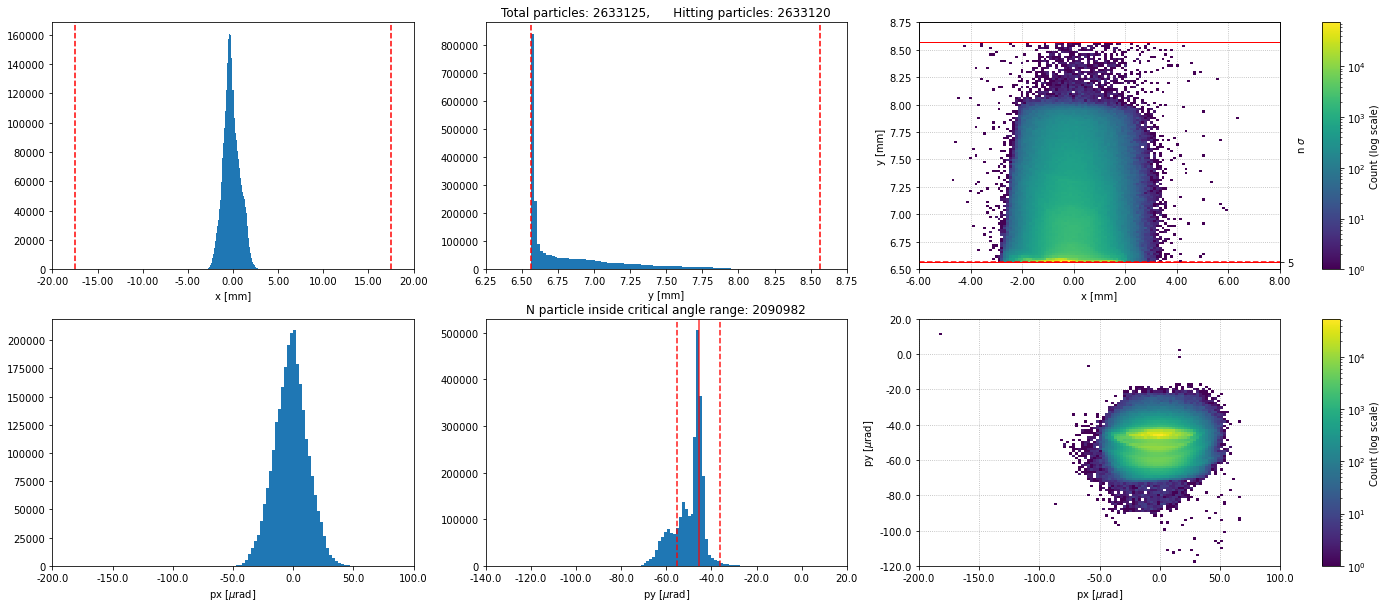

In [169]:
TCCS_inj.load_particles(inj,'TCCS_impacts')
TCCS_inj.compute_impact_particles(xpcrit = True)

!!! Succesful Jobs:  98 / 100  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TEST_TWOCRYST_double_channeling_inj___20240528-1755


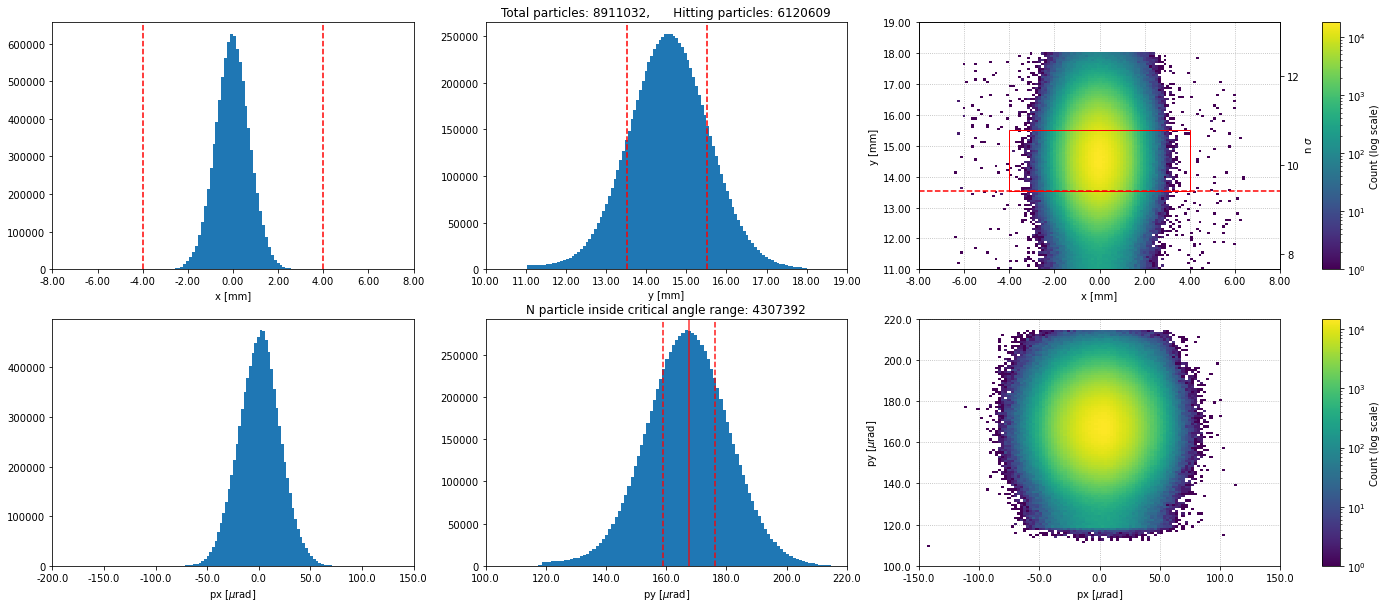

In [170]:
TCCP_inj.load_particles(inj,'TCCP_impacts')
TCCP_inj.compute_impact_particles(xpcrit = True)

!!! Succesful Jobs:  98 / 100  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TEST_TWOCRYST_double_channeling_inj___20240528-1755
There are repeated particle ids!


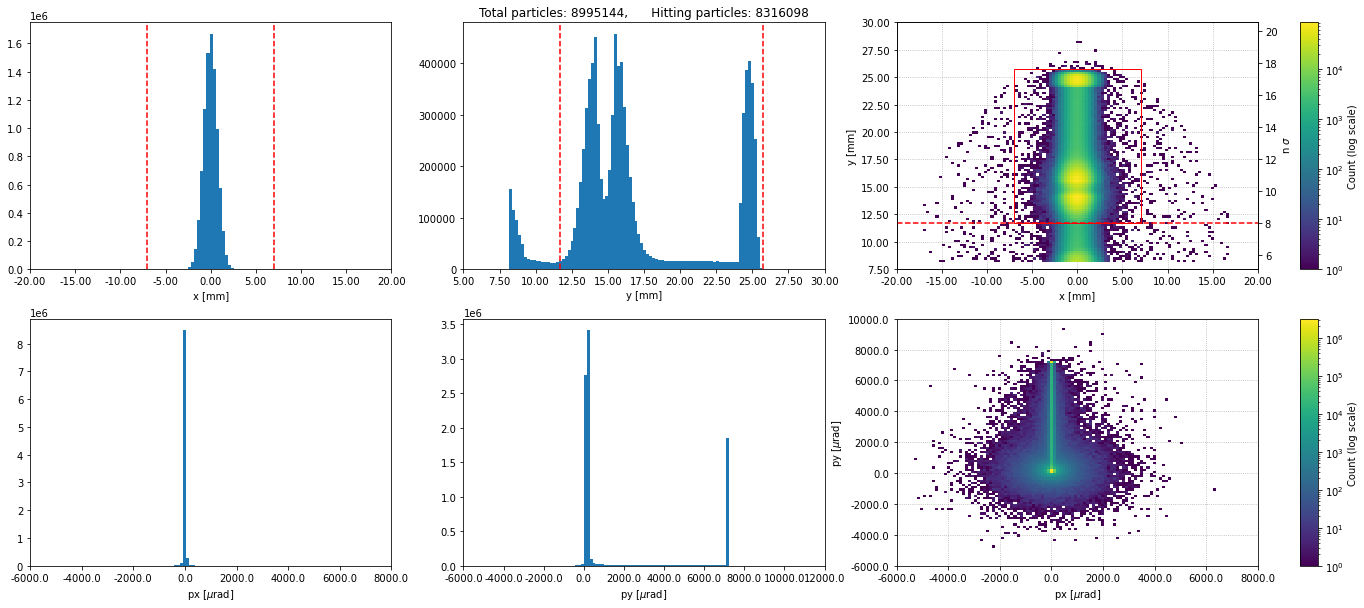

In [171]:
PIXEL_inj.load_particles(inj,'PIXEL_impacts')
PIXEL_inj.compute_impact_particles(xpcrit = True)

## 1 TeV test

In [35]:
tev1 = 'TEST_TWOCRYST_double_channeling_1tev___20240529-1821'

In [40]:
TCCP_tev1 = CrystalAnalysis(n_sigma=12.5, length=0.07, ydim=0.002, xdim=0.008,bending_radius=10.0, align_angle=0.00015686418575392125, sigma=0.0009633910371268278, jaw_L=0.01204194027767872)
PIXEL_tev1 = TargetAnalysis(n_sigma=9.6, target_type = 'pixel', ydim=0.01408, xdim=0.04224,sigma=0.0009710136328675665)
ALFA_tev1 = TargetAnalysis(n_sigma=9.0, target_type='alfa', ydim=0.0297, xdim=0.04525,sigma=0.0009785071670703218)

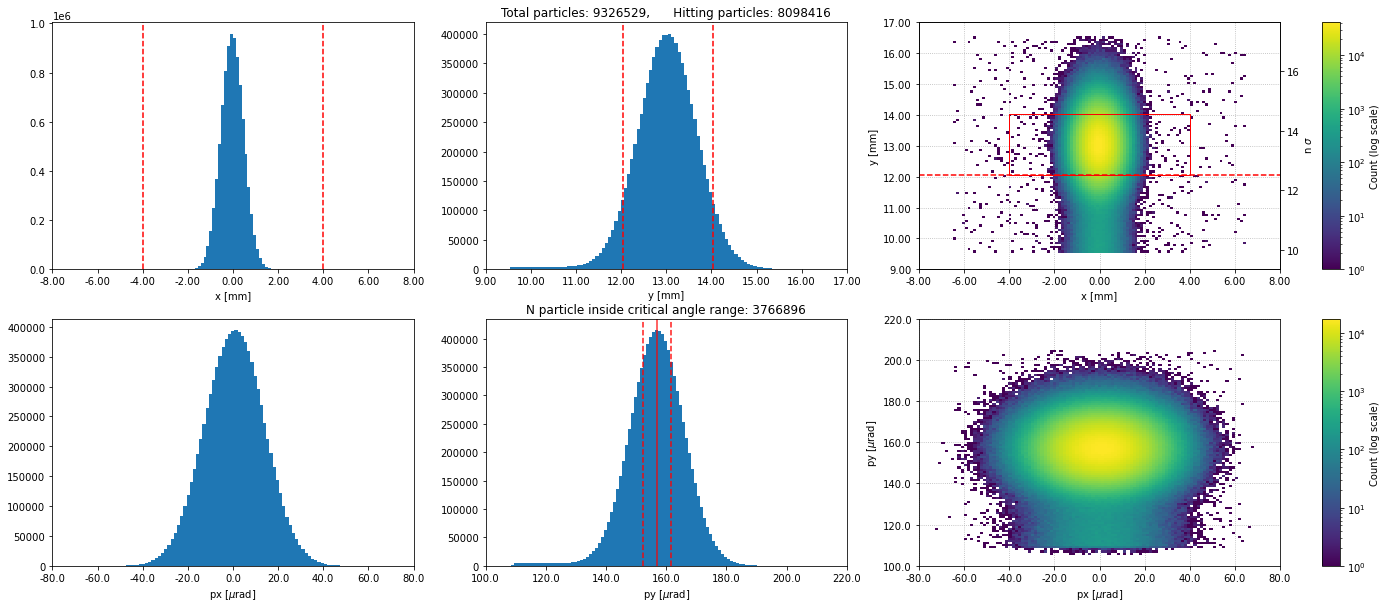

In [41]:
TCCP_tev1.load_particles(tev1, 'TCCP_impacts')
TCCP_tev1.compute_impact_particles(xpcrit = True)

There are repeated particle ids!


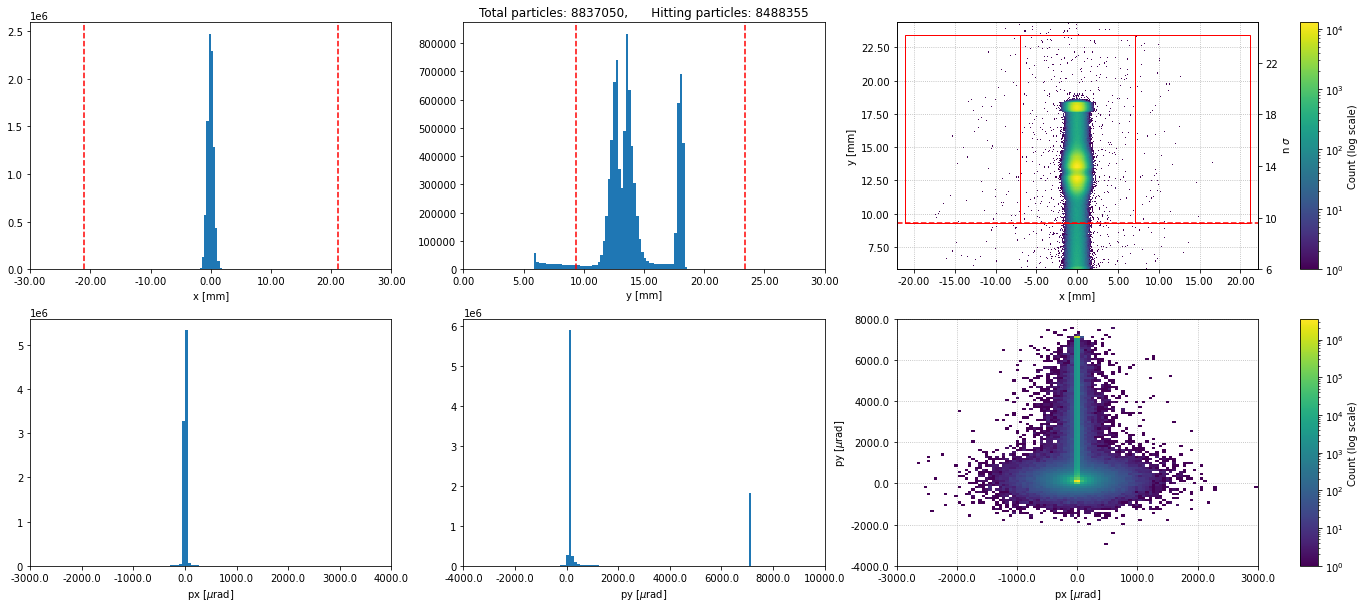

In [42]:
PIXEL_tev1.load_particles(tev1, 'PIXEL_impacts')
PIXEL_tev1.compute_impact_particles()

There are repeated particle ids!


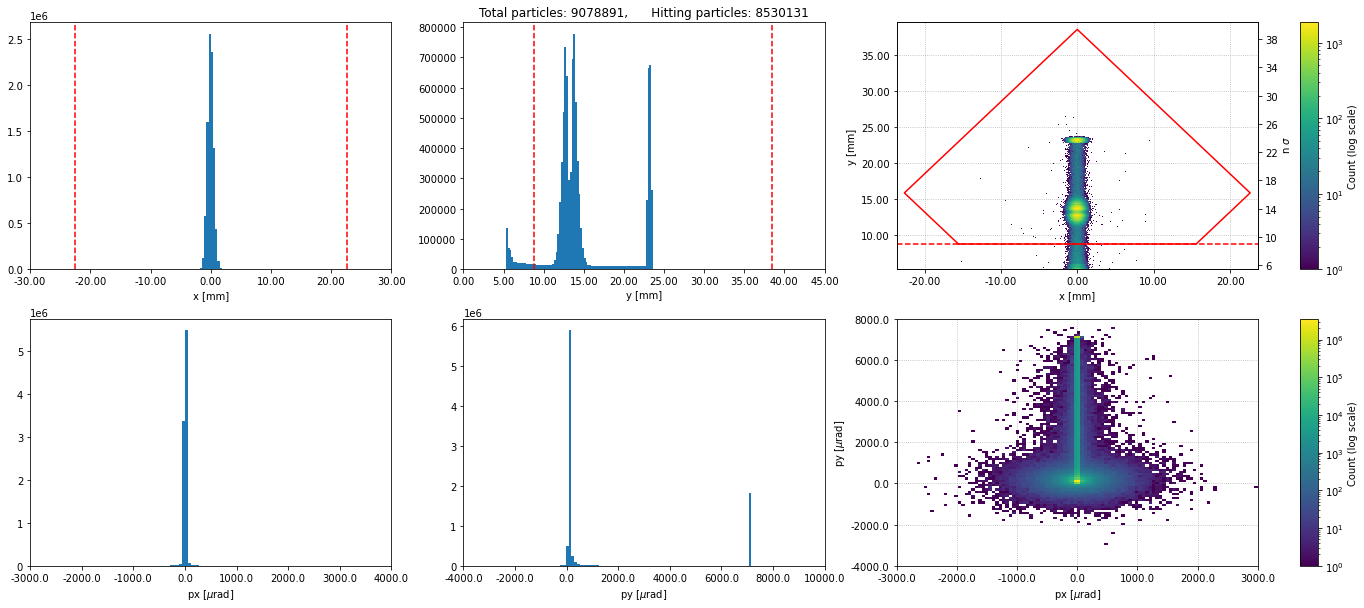

In [43]:
ALFA_tev1.load_particles(tev1, 'ALFA_impacts')
ALFA_tev1.compute_impact_particles()

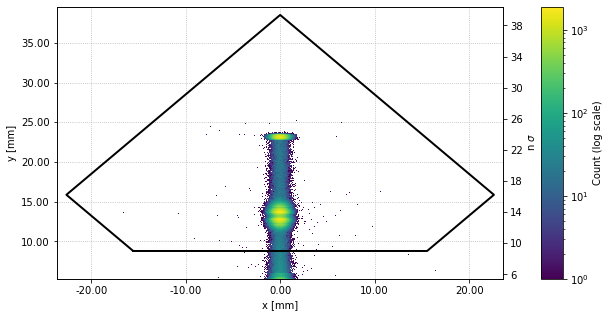

In [44]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot()
x = ALFA_tev1.data['x']
y = ALFA_tev1.data['y']

angles = [180-135, 90, 90, 90,135] 
side_lengths = [31.1e-3, 10e-3, 32e-3, 32e-3, 10e-3]  
angles = np.radians(angles)

ALFA_x = [0]
ALFA_y = [0]
for i in range(len(side_lengths)):
    angle_sum = np.sum(angles[:i])
    ALFA_x.append(ALFA_x[-1] + side_lengths[i] * np.cos(angle_sum))
    ALFA_y.append(ALFA_y[-1] + side_lengths[i] * np.sin(angle_sum))
# Close the pentagon by appending the first vertex at the end
ALFA_x.append(ALFA_x[0])
ALFA_y.append(ALFA_y[0])

# Center in x an apply vertical offset
jaw_L = ALFA_tev1.jaw_L
ALFA_x = [i -side_lengths[0]/2 for i in ALFA_x]
ALFA_y = [i + jaw_L for i in ALFA_y]

ALFA_tev1.plot_xy_distribution(fig, ax, x, y,  xlim = [min(ALFA_x)-1e-3, max(ALFA_x)+1e-3], ylim = [ALFA_tev1.jaw_L-3.5e-3, max(ALFA_y)+1e-3], bins = (round(ALFA_tev1.xdim /30e-6), round(ALFA_tev1.ydim /30e-6)), sigma_line = False)
ax.plot(ALFA_x, ALFA_y, 'k', linewidth = 2)

#fig.savefig('./Plots/ALFA_tev1.png', dpi=400, bbox_inches='tight')


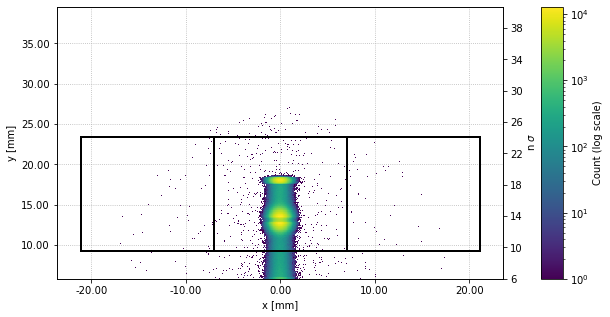

In [45]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot()
x = PIXEL_tev1.data['x']
y = PIXEL_tev1.data['y']
PIXEL_tev1.plot_xy_distribution(fig, ax, x, y, xlim = [min(ALFA_x)-1e-3, max(ALFA_x)+1e-3], ylim = [PIXEL_tev1.jaw_L-3.5e-3, max(ALFA_y)+1e-3], bins = (round(PIXEL_tev1.xdim /55e-6), round(PIXEL_tev1.ydim /55e-6)), sigma_line = False   )            
PIXEL_tev1.plot_rectangle(ax, PIXEL_tev1.abs_x_low, PIXEL_tev1.abs_x_low + PIXEL_tev1.xdim/3, PIXEL_tev1.abs_y_low, PIXEL_tev1.abs_y_up, edgecolor = 'k', linewidth=2)
PIXEL_tev1.plot_rectangle(ax, PIXEL_tev1.abs_x_low + PIXEL_tev1.xdim/3, PIXEL_tev1.abs_x_low + PIXEL_tev1.xdim/3*2, PIXEL_tev1.abs_y_low, PIXEL_tev1.abs_y_up, edgecolor = 'k', linewidth=2)
PIXEL_tev1.plot_rectangle(ax, PIXEL_tev1.abs_x_low + PIXEL_tev1.xdim/3*2, PIXEL_tev1.abs_x_up, PIXEL_tev1.abs_y_low, PIXEL_tev1.abs_y_up, edgecolor = 'k', linewidth=2)

#fig.savefig('./Plots/PIXEL_tev1.png', dpi=400, bbox_inches='tight') 

In [ ]:
TARGET_ft_C = TargetAnalysis(n_sigma=27.0, target_type = 'target', length=0.005, ydim=0.002, xdim=0.008,sigma=0.0003694706693370014, jaw_L=0.009987944965736269)
tft = 'RUN3_ANG_SCAN_-2.1__target_absorber_20240502-1051'
TARGET_ft_C.load_particles(tft, 'TARGET_impacts')

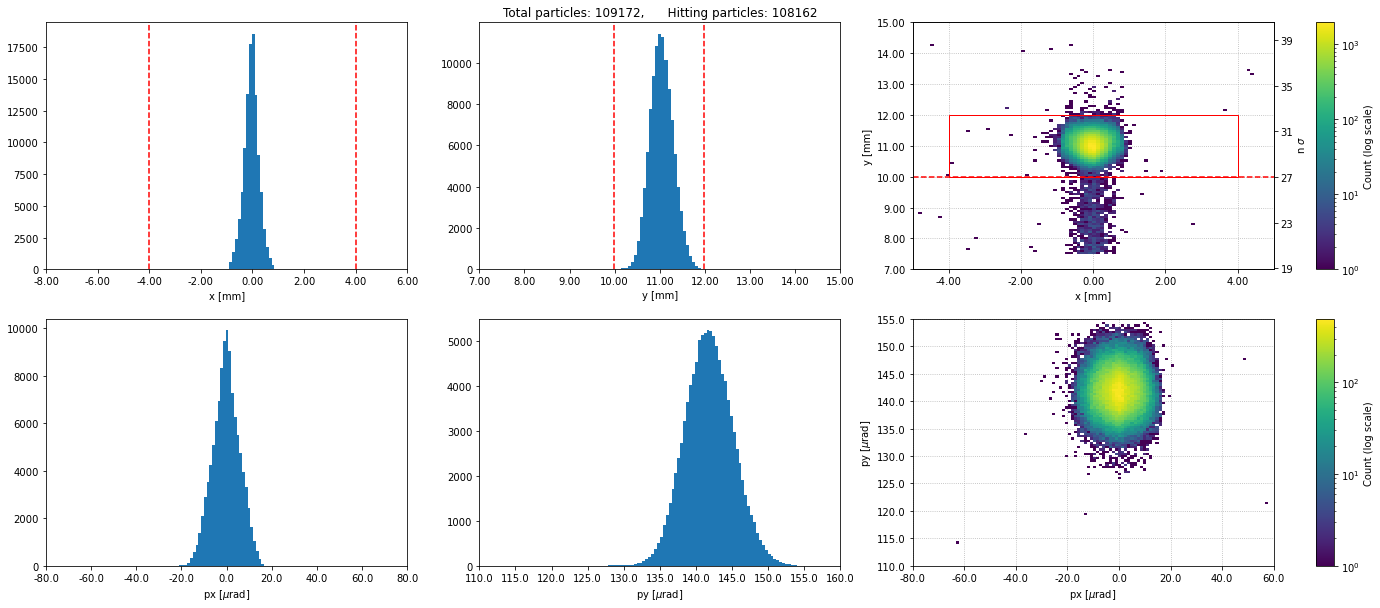

In [59]:
TARGET_ft_C.compute_impact_particles()

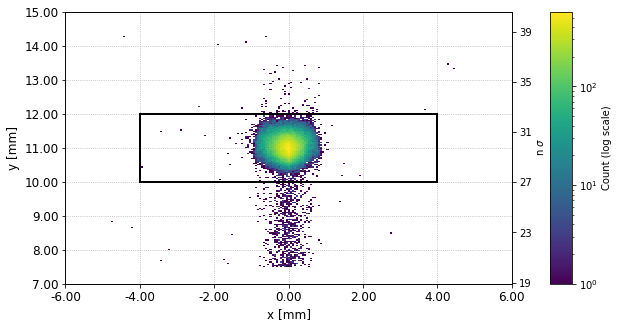

In [74]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot()
ax.set_xlabel('x [mm]', fontsize=12)
ax.set_ylabel('y [mm]', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

x = TARGET_ft_C.data['x']
y = TARGET_ft_C.data['y']
# xlim = [min(ALFA_x)-1e-3, max(ALFA_x)+1e-3], ylim = [TARGET_ft_C.jaw_L-3.5e-3, max(ALFA_y)+1e-3],
TARGET_ft_C.plot_xy_distribution(fig, ax, x, y, xlim =[-0.006, 0.006], bins = (round(200), round(200)), sigma_line = False   )            
TARGET_ft_C.plot_rectangle(ax, TARGET_ft_C.abs_x_low, TARGET_ft_C.abs_x_up, TARGET_ft_C.abs_y_low, TARGET_ft_C.abs_y_up, edgecolor = 'k', linewidth=2)

fig.savefig('./Plots/TARGET_ft_C.png', dpi=400, bbox_inches='tight')


# TWOCRYST TEST

# ANGULAR SCAN

In [33]:
def load_angular_scan(folder_prefix = '', data_dict = None, folder_list = None, cry_name = 'TCCS',  path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/"):
    data_dict = {} if data_dict is None else data_dict
    if folder_list is None:
        folder_list = ls(return_list=True)
        folder_list = [folder for folder in folder_list if folder_prefix in folder]
    for folder in folder_list:
        ang_dict = {}
        ang_key = float(folder.split('__2024')[0].split('_')[-1])
        try :
            file_lines = get_simulation_output(folder, print_1=False, path = path).split('\n')
        except:
            print(f'Skipping {ang_key} \n')
            continue
        for i in range(len(file_lines)):
            if 'CrystalAnalysis' in file_lines[i] and cry_name in file_lines[i-1]:
                ang_dict['obj'] = eval(file_lines[i])
                ang_dict['obj'].load_particles(folder)
                ang_dict['TCCS_abs'] = ang_dict['obj'].n_TCCS_absorbed
                ang_dict['TCCP_abs'] = ang_dict['obj'].n_TCCP_absorbed
                ang_dict['angle'] = ang_dict['obj'].align_angle
                ang_dict['npart'] = ang_dict['obj'].n_jobs*ang_dict['obj'].part_per_job
        data_dict[ang_key] = ang_dict
        data_dict = dict(sorted(data_dict.items()))

    return data_dict


def save_scan(dict_data, file_name, output_path='./Plots/', df_key='scan'):
    dict_copy = copy.deepcopy(dict_data)
    for key in dict_copy.keys():
        del dict_copy[key]['obj']
    df = pd.DataFrame(dict_copy).T.reset_index()
    df.to_hdf(output_path + file_name, key = df_key, mode='w', format='table', complevel=9, complib='blosc')
        

In [39]:
def plot_angular_scan(data_dict, cry_name = 'TCCS', normalize = False):
    fig, ax = plt.subplots(figsize=(10, 5))
    data_dict = data_dict.set_index('index').T.to_dict() if isinstance(data_dict, pd.DataFrame) else data_dict
    n_cry_abs = []
    angles = []
    norm_abs = []
    for key in data_dict.keys():
        n_cry_abs.append(data_dict[key][cry_name+'_abs'])
        angles.append(data_dict[key]['angle'])
        norm_abs.append(data_dict[key][cry_name+'_abs'] / (data_dict[key]['npart'] ))

    if normalize:
        ax.plot(angles, norm_abs, marker='o')
    else:
        ax.plot(angles, n_cry_abs, marker='o')
    ax.set_xlabel('Angle [rad]', fontsize=12)
    ax.set_ylabel('Absorbed particles', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax2 = ax.twiny()
    ax2.plot(data_dict.keys(), norm_abs, alpha=0.0, color='k')
    return fig, ax, ax2

In [35]:
TCCS_ang_scan_450GeV = load_angular_scan(folder_prefix='TWOCRYST_TCCS_ang_scan_450GeV', cry_name='TCCS') #folder_prefix='TWOCRYST_TCCS_ang_scan_450GeV',

KeyboardInterrupt: 

In [36]:
fig, ax, ax2 = plot_angular_scan(TCCS_ang_scan_450GeV, normalize=True)


NameError: name 'TCCS_ang_scan_450GeV' is not defined

In [ ]:
fig.savefig('./Plots/TCCS_ang_scan_450GeV.png', dpi=400, bbox_inches='tight')
save_scan(TCCS_ang_scan_450GeV, 'TCCS_ang_scan_450GeV.h5', df_key='TCCS_scan')

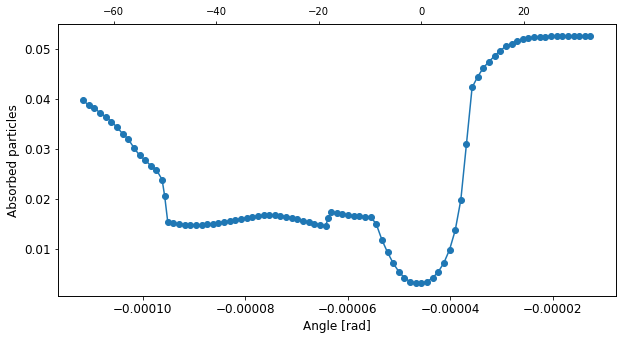

In [42]:
fig, ax, ax2 = plot_angular_scan(pd.read_hdf('./Plots/TCCS_ang_scan_450GeV.h5', key='TCCS_scan'), normalize=True)
#ax.set_yscale('log')
#ax.axvline(TCCS_ang_scan_450GeV[0]['obj'].align_angle, color='r', linestyle='--')
#ax.axvline(TCCS_ang_scan_450GeV[0]['obj'].align_angle+TCCS_ang_scan_450GeV[0]['obj'].xp_crit, color='g', linestyle='--')
#ax.axvline(TCCS_ang_scan_450GeV[0]['obj'].align_angle-TCCS_ang_scan_450GeV[0]['obj'].xp_crit, color='g', linestyle='--')

In [305]:
TCCS_ang_scan_450GeV = load_angular_scan(folder_prefix='TWOCRYST_TCCS_ang_scan_NOTRANS_450GeV', cry_name='TCCS')

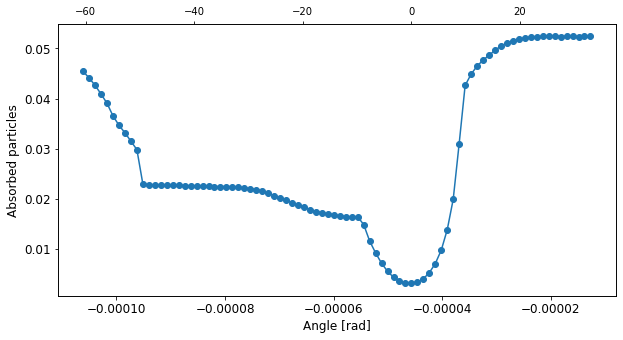

In [45]:
fig, ax, ax2 = plot_angular_scan(pd.read_hdf('./Plots/TCCS_ang_scan_450GeV_NOTRANS.h5', key='TCCS_scan'), normalize=True)
#ax.axvline(TCCS_ang_scan_450GeV[0]['obj'].align_angle, color='r', linestyle='--')
#ax.axvline(TCCS_ang_scan_450GeV[0]['obj'].align_angle+TCCS_ang_scan_450GeV[0]['obj'].xp_crit, color='g', linestyle='--')
#ax.axvline(TCCS_ang_scan_450GeV[0]['obj'].align_angle-TCCS_ang_scan_450GeV[0]['obj'].xp_crit, color='g', linestyle='--')

In [307]:
fig.savefig('./Plots/TCCS_ang_scan_450GeV_NOTRANS.png', dpi=400, bbox_inches='tight')
save_scan(TCCS_ang_scan_450GeV, 'TCCS_ang_scan_450GeV_NOTRANS.h5', df_key='TCCS_scan')

In [49]:
pd.read_hdf('./Plots/TCCS_ang_scan_450GeV_NOTRANS.h5', key='TCCS_scan')

,index,TCCS_abs,TCCP_abs,angle,npart
0,-60.5,45399.0,0.0,-0.000106,1000000.0
1,-59.4,44089.0,0.0,-0.000105,1000000.0
2,-58.3,42617.0,0.0,-0.000104,1000000.0
3,-57.2,40888.0,0.0,-0.000103,1000000.0
4,-56.1,39035.0,0.0,-0.000102,1000000.0
...,...,...,...,...,...
81,28.6,52374.0,0.0,-0.000017,1000000.0
82,29.7,52371.0,0.0,-0.000016,1000000.0
83,30.8,52366.0,0.0,-0.000015,1000000.0
84,31.9,52374.0,0.0,-0.000014,1000000.0


# LINEAR SCAN

## TCCS 450 GeV

In [6]:
TCCS_lin_scan_inj = 'TWOCRYST_TCCS_lin_scan_450GeV_v1_20241112-1724'

In [7]:
TCCS_ls = CrystalAnalysis(n_sigma=5.0, length=0.004, ydim=0.002, xdim=0.035,bending_radius=80.0, align_angle=-4.56391e-05, miscut = 0, sigma=0.0013154072397225786, jaw_L=0.006577401104394332)
TCLA_ls = TargetAnalysis(n_sigma=5.0, target_type='collimator', length=1, ydim=0.025, xdim=0.025,sigma=0.0011392666165194847,  jaw_L=0.005696548206192878)

In [8]:
TCLA_ls.load_particles(TCCS_lin_scan_inj, 'TCLA_impacts')


There are repeated particle ids!


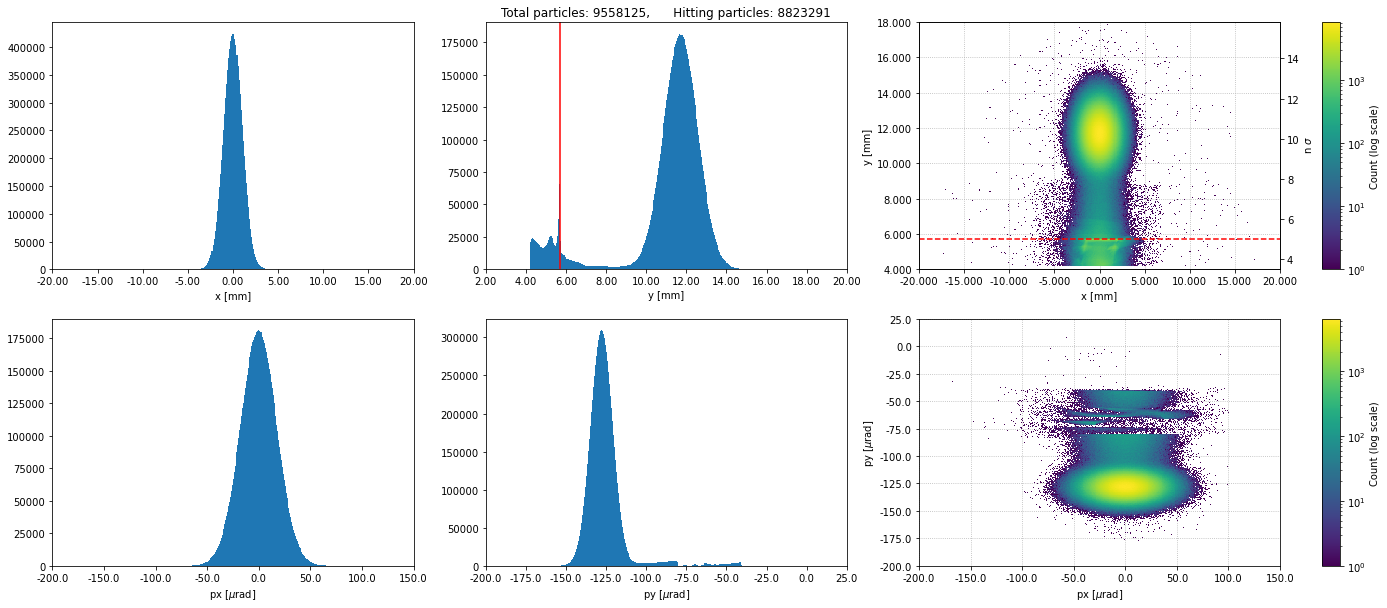

In [9]:
TCLA_ls.compute_impact_particles(bins=300)

Height:  0.9646364894697735  a.u.
Mean:  0.011716107277033436  mm
Sigma:  0.0008536828194029655  mm
Calculated theta [urad]:  50.209
Efficiency:  96.46 %


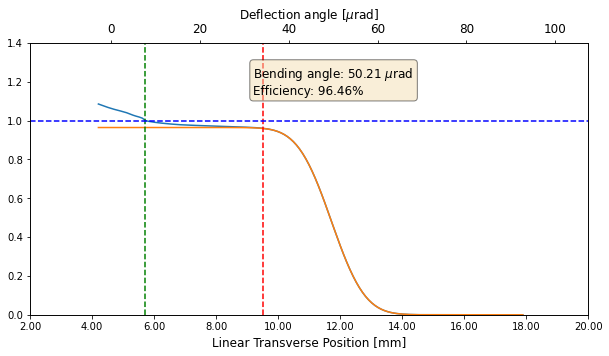

In [11]:
fig, ax, ax2 = TCLA_ls.linear_scan(PosEnvelope=None, PosMaxErfFit= 9.5e-3, param0=[0.5, -1, 10e-3, 0.0002], CRY_name = TCCS_name, COLL_name = TCLA_name, config_file = './Archive_config_files/config_sim_TCCS_ang_scan_450GeV.yaml', return_fig=True)

In [ ]:
fig.savefig('./Plots/TCCS_linear_scan_450GeV.png', dpi=400, bbox_inches='tight')

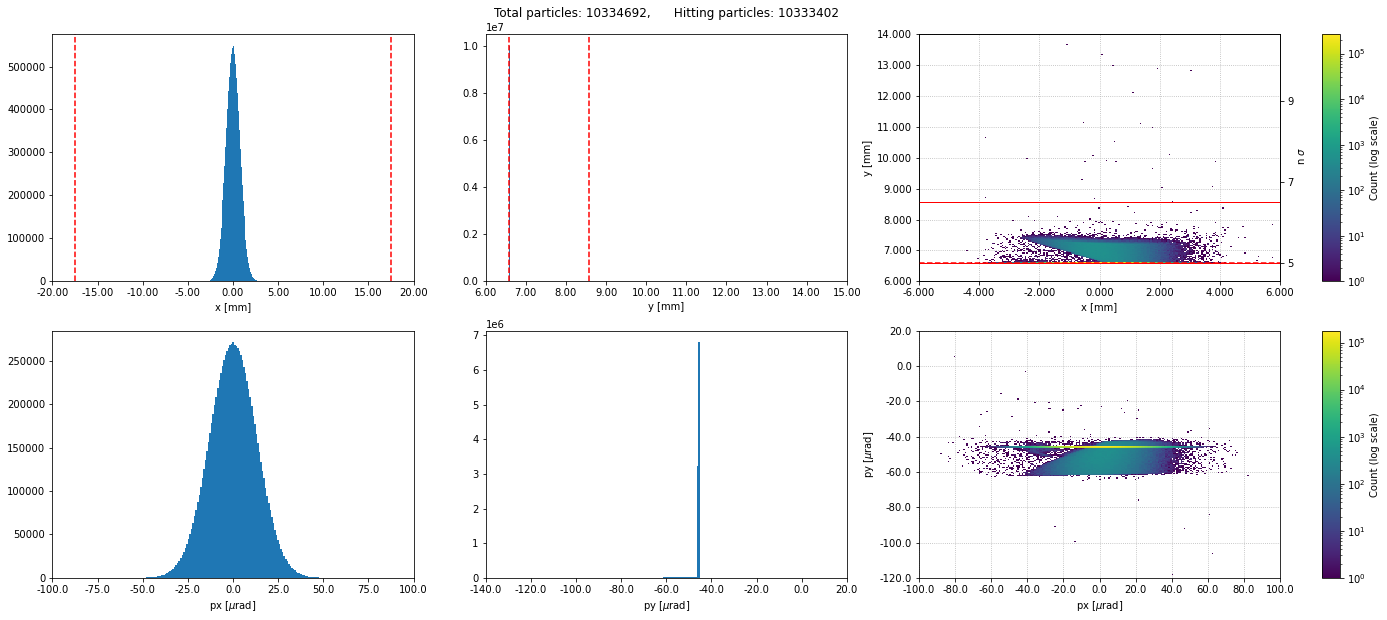

In [8]:
TCCS_ls.load_particles(TCCS_lin_scan_inj, 'TCCS_impacts')
TCCS_ls.compute_impact_particles()

In [10]:
TCCS_ls.channeling_efficiency_sim()

Channeling efficiency: 0.83


In [11]:
TCCS_ls.TCCS_sim_chann_eff

0.8271144284581112

In [12]:
TCCS_ls.channeling_efficiency_sim(half=True)

Channeling efficiency: 0.83


In [6]:
TCCS_lin_scan_inj_open = 'TWOCRYST_TCCS_lin_scan_450GeV_open_20241113-0917'

In [7]:
TCCS_ls_open = CrystalAnalysis(n_sigma=5.0, length=0.004, ydim=0.002, xdim=0.035,bending_radius=80.0, align_angle=-4.56391e-05, miscut = 0, sigma=0.0013154072397225786, jaw_L=0.006577401104394332)
TCLA_ls_open = TargetAnalysis(n_sigma=8.0, target_type='collimator', length=1, ydim=0.025, xdim=0.025,sigma=0.0011392666165194847,  jaw_L=0.00911434805575133)

In [8]:
TCLA_ls_open.load_particles(TCCS_lin_scan_inj_open, 'TCLA_impacts')

There are repeated particle ids!


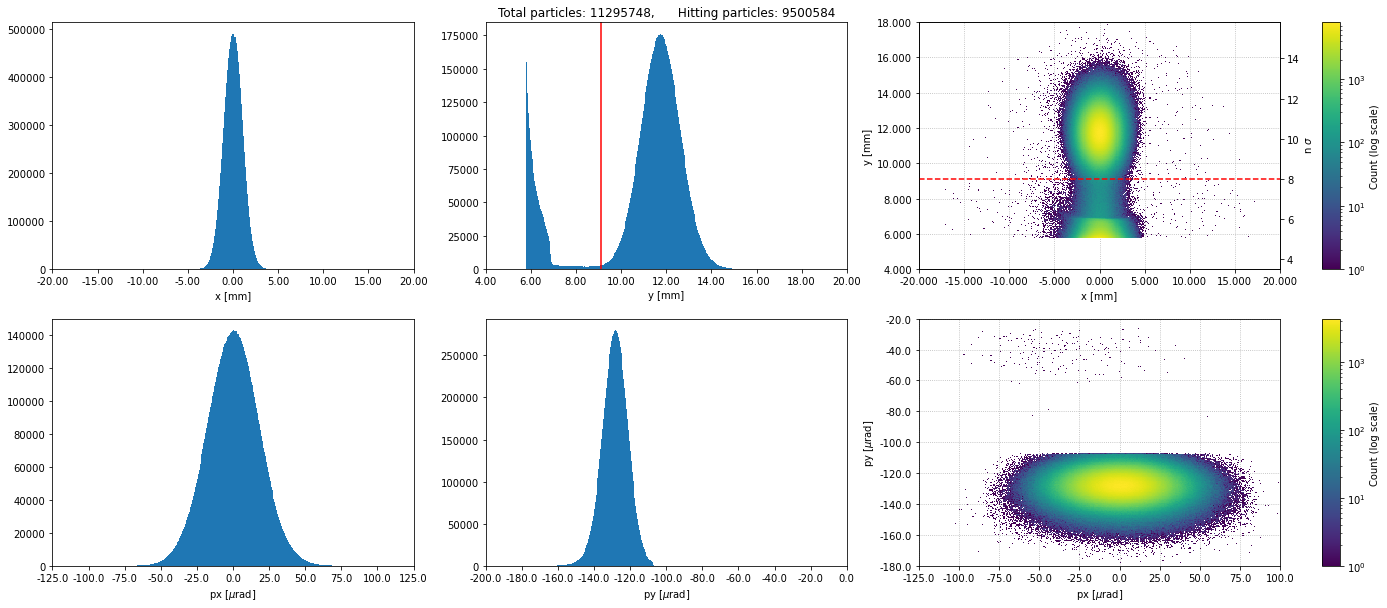

In [9]:
fig, ax = TCLA_ls_open.compute_impact_particles(bins=300, return_fig=True)

Height:  0.9826147090877763  a.u.
Mean:  0.01175229474946055  mm
Sigma:  0.0008757800594773497  mm
Calculated theta [urad]:  55.119
Efficiency:  98.26 %


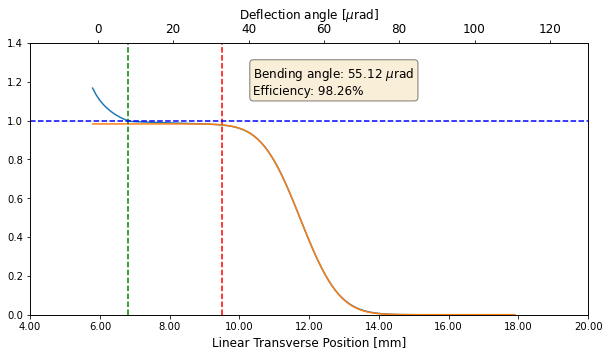

In [15]:
fig, ax, ax2 = TCLA_ls_open.linear_scan(PosEnvelope=6.8e-3, PosMaxErfFit= 9.5e-3, param0=[0.5, -1, 10e-3, 0.0002], CRY_name = TCCS_name, COLL_name = TCLA_name, config_file = './Archive_config_files/config_sim_TCCS_ang_scan_450GeV.yaml', return_fig=True)

In [16]:
fig.savefig('./Plots/TCCS_linear_scan_450GeV_open.png', dpi=400, bbox_inches='tight')

# DOUBLE CHANNELING

## 450 GeV

In [46]:
#gev450 = 'TWOCRYST_450GeV_DC_v0__20241030-1755'
gev450 = 'TWOCRYST_450GeV_DC_v0__20241112-1137'

In [51]:
TCCS_Gev450 = CrystalAnalysis(n_sigma=5.0, length=0.004, ydim=0.002, xdim=0.035,bending_radius=80.0, align_angle=-4.56391e-05, miscut = 0, sigma=0.0013154072397225786, jaw_L=0.006577401104394332)
TCCP_Gev450 = CrystalAnalysis(n_sigma=9.4, length=0.07, ydim=0.002, xdim=0.008,bending_radius=10.0, align_angle=0.0001681303, miscut = 0, sigma=0.0014388821741249081, jaw_L=0.013525836359445455)
PIXEL1_Gev450 = TargetAnalysis(n_sigma=5.5, target_type = 'pixel', ydim=0.01408, xdim=0.04224,sigma=0.001447962320253603)
PIXEL2_Gev450 = TargetAnalysis(n_sigma=5.5, target_type = 'pixel', ydim=0.01408, xdim=0.04224,sigma=0.001447962320253603)
PIXEL3_Gev450 = TargetAnalysis(n_sigma=5.5, target_type = 'pixel', ydim=0.01408, xdim=0.04224,sigma=0.001447962320253603)
TFT_Gev450 = TargetAnalysis(n_sigma=6.4, target_type='alfa', ydim=0.0297, xdim=0.04525,sigma=0.0014571339362266342)

In [49]:
TCCS_Gev450.load_particles(gev450,'TCCS_impacts')

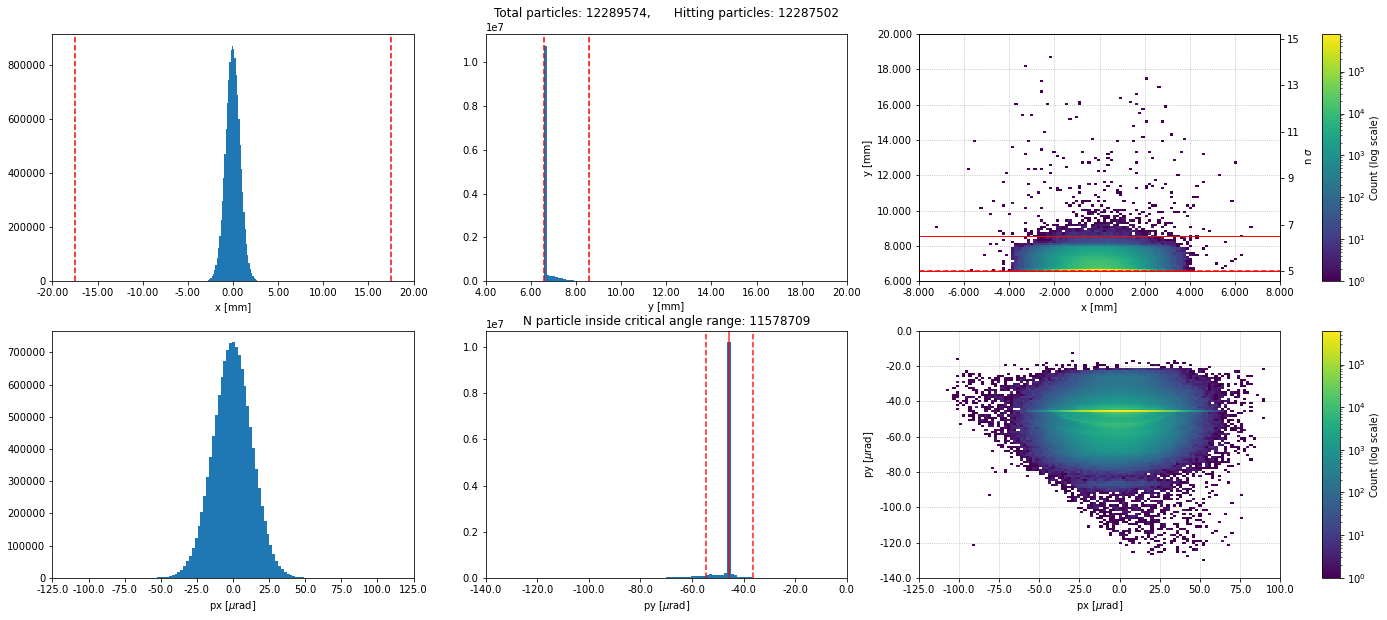

In [50]:
TCCS_Gev450.compute_impact_particles(xpcrit = True)

In [65]:
TCCP_Gev450.TCCS_sim_chann_eff

0.8139789447279102

In [66]:
TCCP_Gev450.xp_crit

8.25330097732552e-06

In [52]:
TCCP_Gev450.load_particles(gev450,'TCCP_impacts')

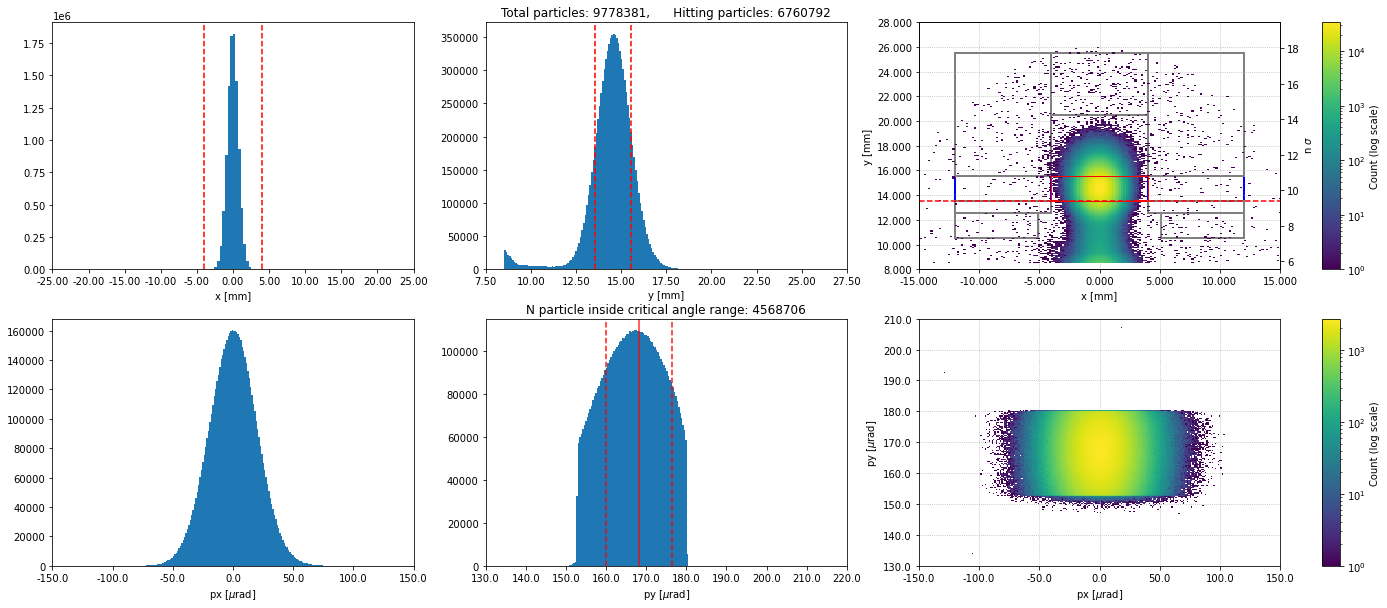

In [53]:
TCCP_Gev450.compute_impact_particles(xpcrit = True, plot_support =  True)

In [41]:
PIXEL1_Gev450.load_particles(gev450,'PIXEL_impacts_1')

!!! Succesful Jobs:  199 / 200  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TWOCRYST_450GeV_DC_v0__20241030-1755
There are repeated particle ids!


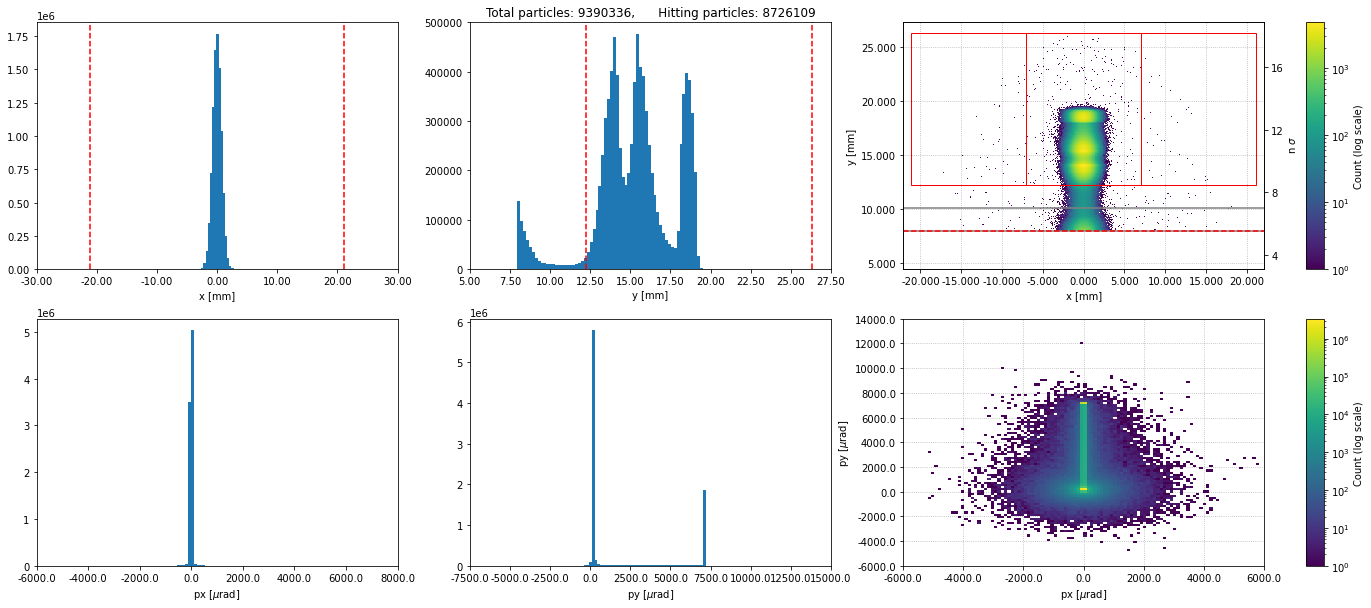

In [43]:
PIXEL1_Gev450.compute_impact_particles()

In [44]:
TFT_Gev450.load_particles(gev450,'TFT_impacts')

!!! Succesful Jobs:  199 / 200  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TWOCRYST_450GeV_DC_v0__20241030-1755
There are repeated particle ids!


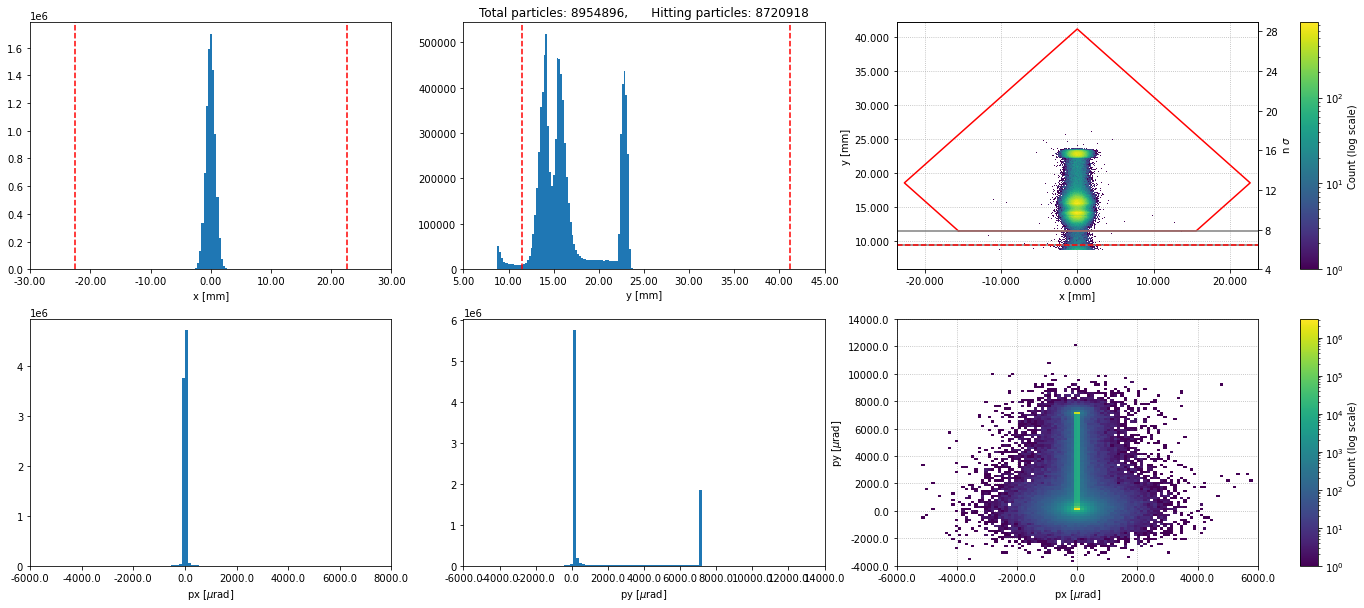

In [45]:
TFT_Gev450.compute_impact_particles()

## 1 TeV

In [37]:
#Tev1 = 'TWOCRYST_1000GeV_DC_v0__20241030-1754'
Tev1 = 'TWOCRYST_1000GeV_DC_v0__20241112-1134'

In [38]:
TCCP_Tev1 = CrystalAnalysis(n_sigma=12.5, length=0.07, ydim=0.002, xdim=0.008,bending_radius=10.0, align_angle=0.0001570598, miscut = 0, sigma=0.0009652315726219019, jaw_L=0.012065730950244019)
PIXEL1_Tev1 = TargetAnalysis(n_sigma=6.4, target_type = 'pixel', ydim=0.01408, xdim=0.04224,sigma=0.000971322717849412)
PIXEL2_Tev1 = TargetAnalysis(n_sigma=6.4, target_type = 'pixel', ydim=0.01408, xdim=0.04224,sigma=0.000971322717849412)
PIXEL3_Tev1 = TargetAnalysis(n_sigma=6.4, target_type = 'pixel', ydim=0.01408, xdim=0.04224,sigma=0.000971322717849412)
TFT_Tev1 = TargetAnalysis(n_sigma=8.6, target_type='alfa', ydim=0.0297, xdim=0.04525,sigma=0.0009774752228941333)

In [39]:
TCCP_Tev1.load_particles(Tev1, df_key="TCCP_impacts", get_absorbed='all')

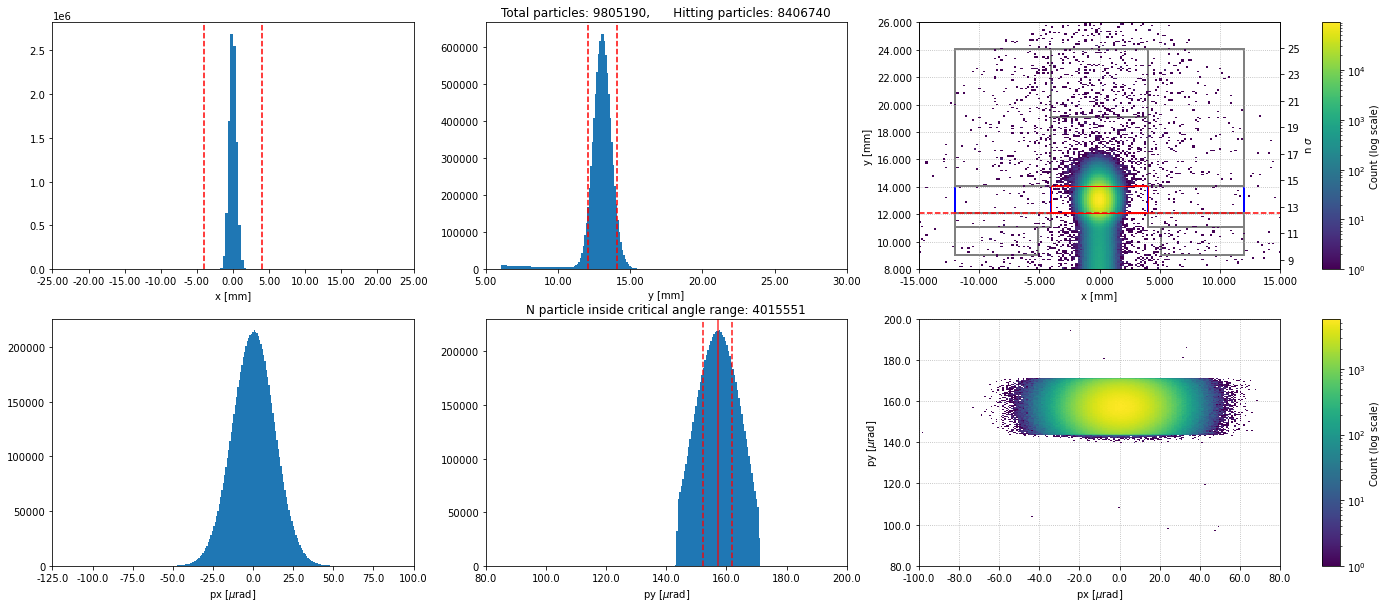

In [43]:
TCCP_Tev1.compute_impact_particles(xpcrit=True, plot_support = True)

In [22]:
TCCP_Tev1.channeling_efficiency_sim()

No interaction data available --  get through TCCS_sim_chann_eff and TCCP_sim_chann_eff


In [23]:
TCCP_Tev1.TCCP_sim_chann_eff

0.3904620985829472

In [24]:
PIXEL1_Tev1.load_particles(Tev1, df_key="PIXEL_impacts_1")

There are repeated particle ids!


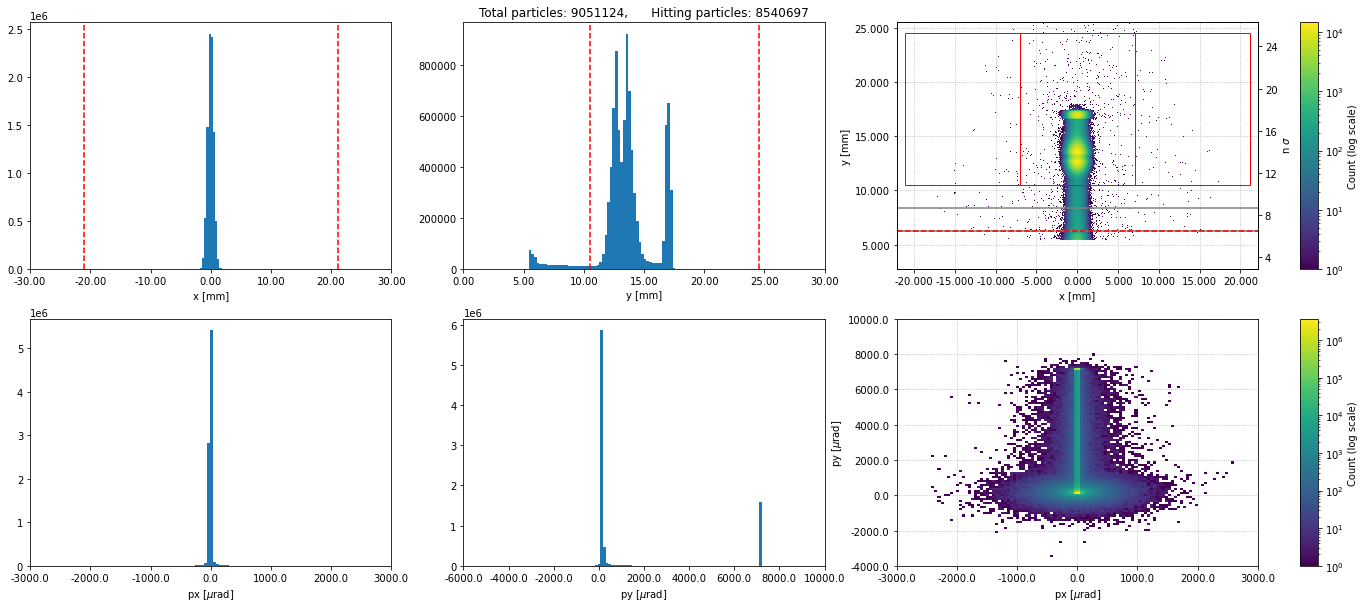

In [25]:
PIXEL1_Tev1.compute_impact_particles()

In [26]:
PIXEL3_Tev1.load_particles(Tev1, df_key="PIXEL_impacts_3")

There are repeated particle ids!


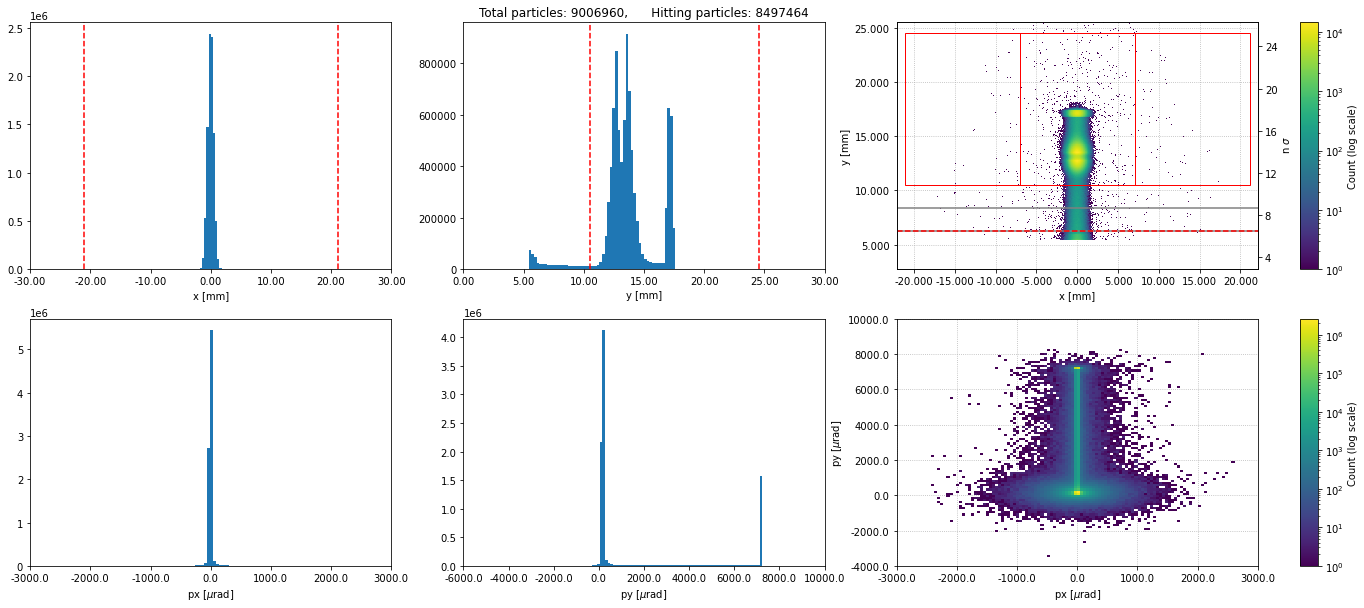

In [30]:
PIXEL3_Tev1.compute_impact_particles()

In [27]:
TFT_Tev1.load_particles(Tev1, df_key="TFT_impacts")

There are repeated particle ids!


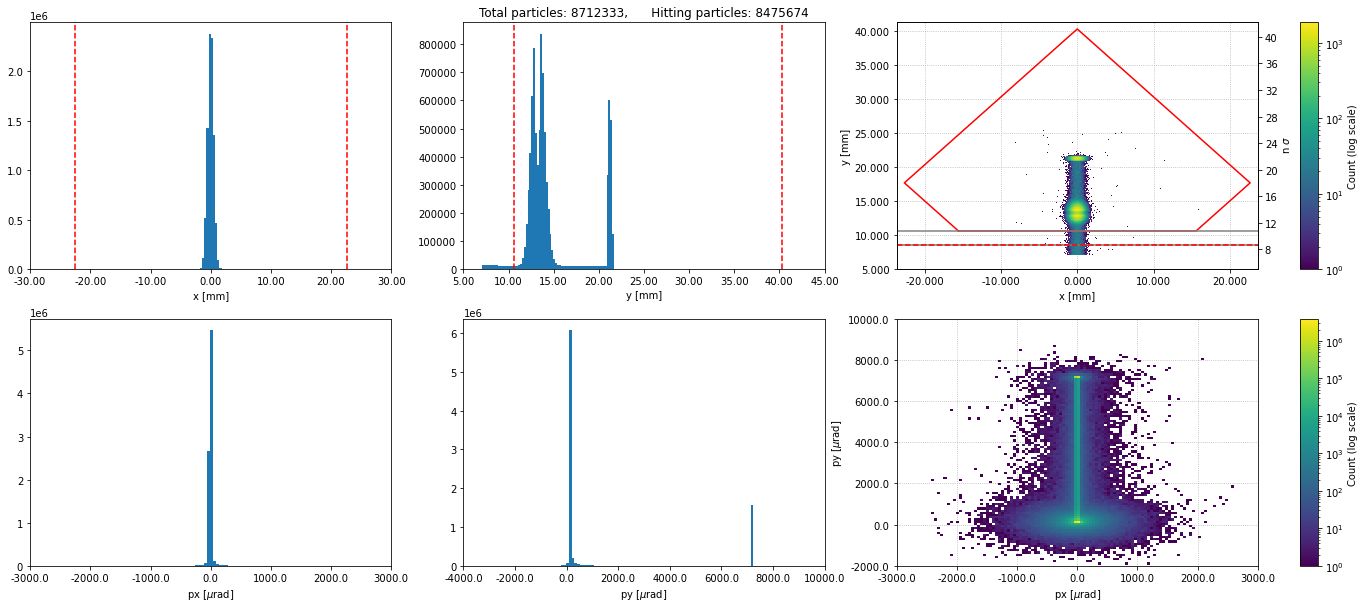

In [28]:
TFT_Tev1.compute_impact_particles()

In [ ]:
tev1_full = 'TWOCRYST_1000GeV_DC_v4__20241028-1426'

In [ ]:
TCCP_Tev1_full = CrystalAnalysis(n_sigma=12.5, length=0.07, ydim=0.002, xdim=0.008,bending_radius=10.0, align_angle=0.0001570598, miscut = 0, sigma=0.0009652315726219019, jaw_L=0.012065730950244019)
PIXEL1_Tev1_full = TargetAnalysis(n_sigma=6.4, target_type = 'pixel', ydim=0.01408, xdim=0.04224,sigma=0.000971322717849412)
TFT_Tev1_full = TargetAnalysis(n_sigma=8.6, target_type='alfa', ydim=0.0297, xdim=0.04525,sigma=0.0009774752228941333)

In [ ]:
TCCP_Tev1_full.load_particles(tev1_full, df_key="TCCP_impacts", get_absorbed='all')

In [ ]:
TCCP_Tev1_full.count_interactions()

interactions
['CH', 'A']                                                                           56459
['CH', 'C', 'MCS', 'A']                                                                   1
['CH', 'C', 'MCS', 'SD', 'MCS']                                                           1
['CH', 'C', 'MCS', 'VR', 'MCS', 'A']                                                      1
['CH', 'C', 'MCS', 'VR', 'MCS', 'PN', 'MCS']                                              1
['CH', 'C', 'MCS', 'VR', 'MCS']                                                          31
['CH', 'C', 'MCS']                                                                       32
['CH', 'DCH', 'MCS', 'A']                                                             31358
['CH', 'DCH', 'MCS', 'C', 'MCS', 'A']                                                     3
['CH', 'DCH', 'MCS', 'C', 'MCS']                                                         26
['CH', 'DCH', 'MCS', 'PN', 'MCS', 'A']                             

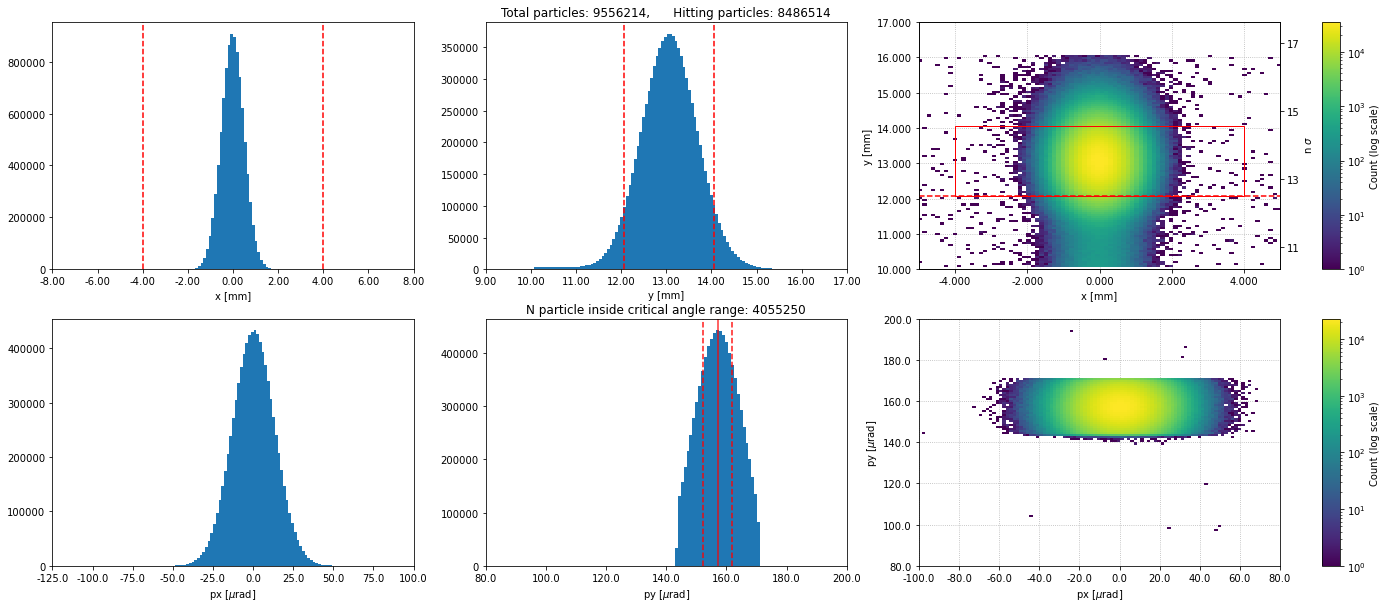

In [ ]:
TCCP_Tev1_full.compute_impact_particles(xpcrit=True)

In [ ]:
PIXEL1_Tev1_full.load_particles(tev1_full, df_key="PIXEL_impacts_1")

There are repeated particle ids!


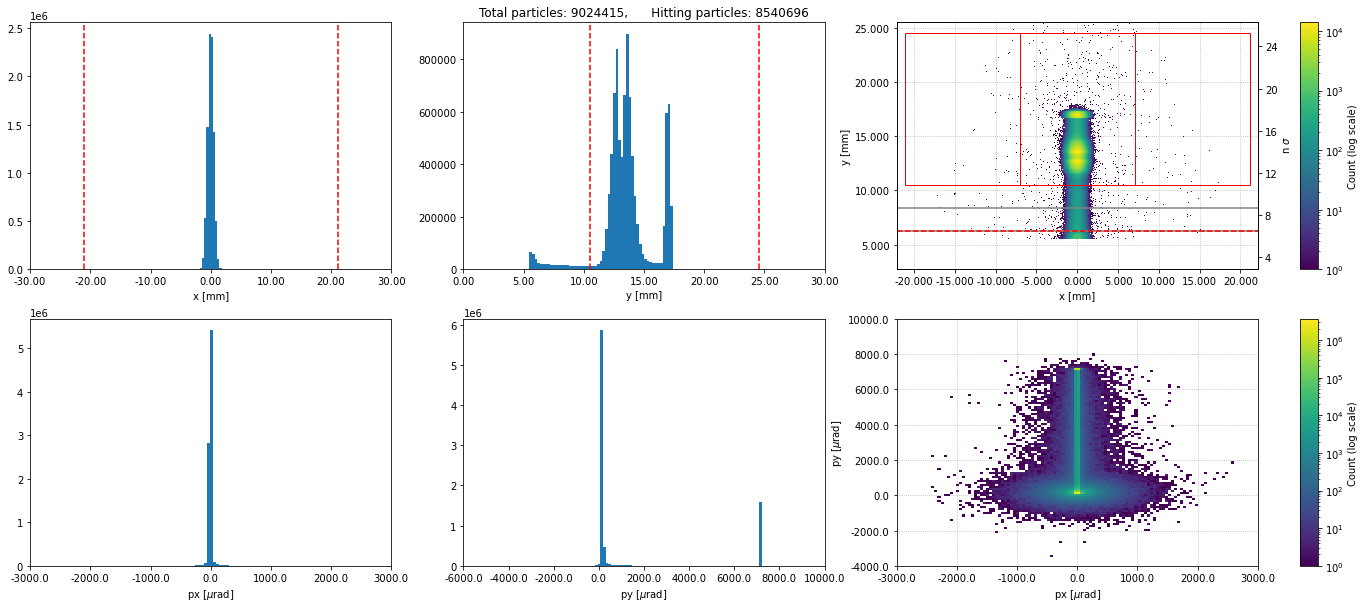

In [ ]:
PIXEL1_Tev1_full.compute_impact_particles()

In [ ]:
TFT_Tev1_full.load_particles(tev1_full, df_key="TFT_impacts")

There are repeated particle ids!


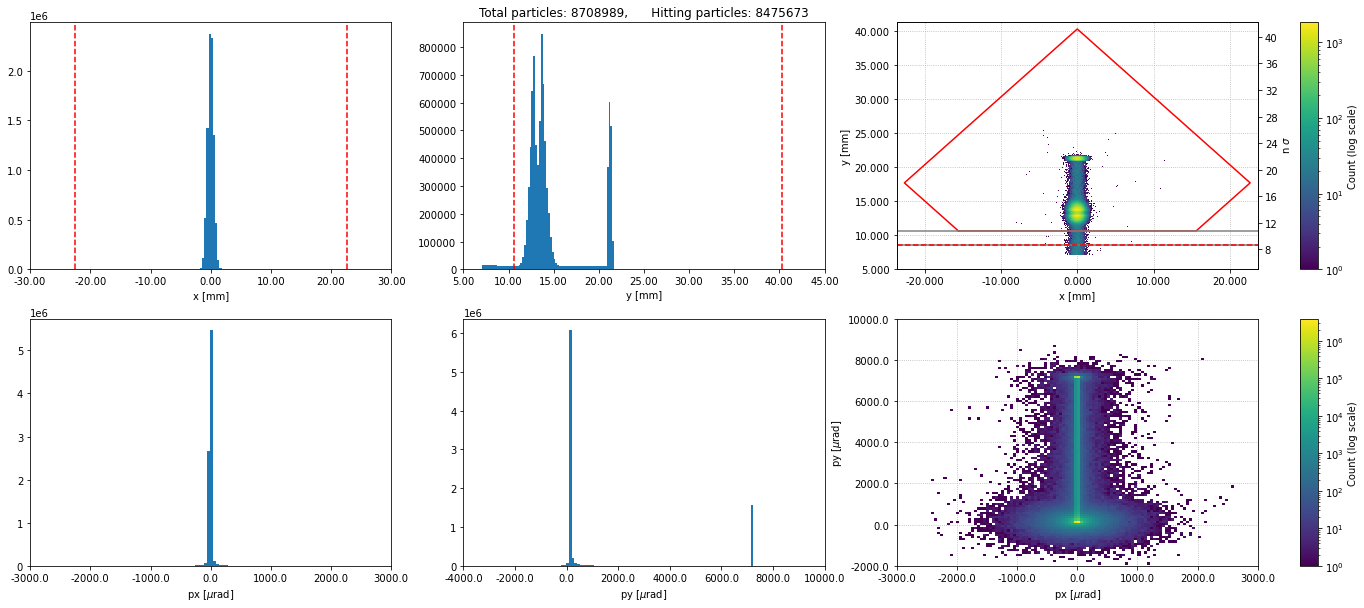

In [ ]:
TFT_Tev1_full.compute_impact_particles()

In [ ]:
TCCP_Tev1_full.channeling_efficiency_sim()

Channeling efficiency: 0.39


## 3 TeV

In [54]:
#tev3 = 'TWOCRYST_3000GeV_DC_v1__20241031-1528'
tev3 = 'TWOCRYST_3000GeV_DC_v1__20241111-1814'

In [55]:
TCCP_TeV3 = CrystalAnalysis(n_sigma=19.3, length=0.07, ydim=0.002, xdim=0.008,bending_radius=10.0, align_angle=0.0001482704, miscut = 0, sigma=0.0005572767166803468, jaw_L=0.010755775223320323)
PIXEL1_TeV3 = TargetAnalysis(n_sigma=9.64, target_type = 'pixel', ydim=0.01408, xdim=0.04224,sigma=0.0005607934407635198)
PIXEL2_TeV3 = TargetAnalysis(n_sigma=9.64, target_type = 'pixel', ydim=0.01408, xdim=0.04224,sigma=0.0005607934407635198)
PIXEL3_TeV3 = TargetAnalysis(n_sigma=9.64, target_type = 'pixel', ydim=0.01408, xdim=0.04224,sigma=0.0005607934407635198)
TFT_TeV3 = TargetAnalysis(n_sigma=13.48, target_type='alfa', ydim=0.0297, xdim=0.04525,sigma=0.0005643455909511343)

In [56]:
TCCP_TeV3.load_particles(tev3, df_key="TCCP_impacts", get_absorbed='all')

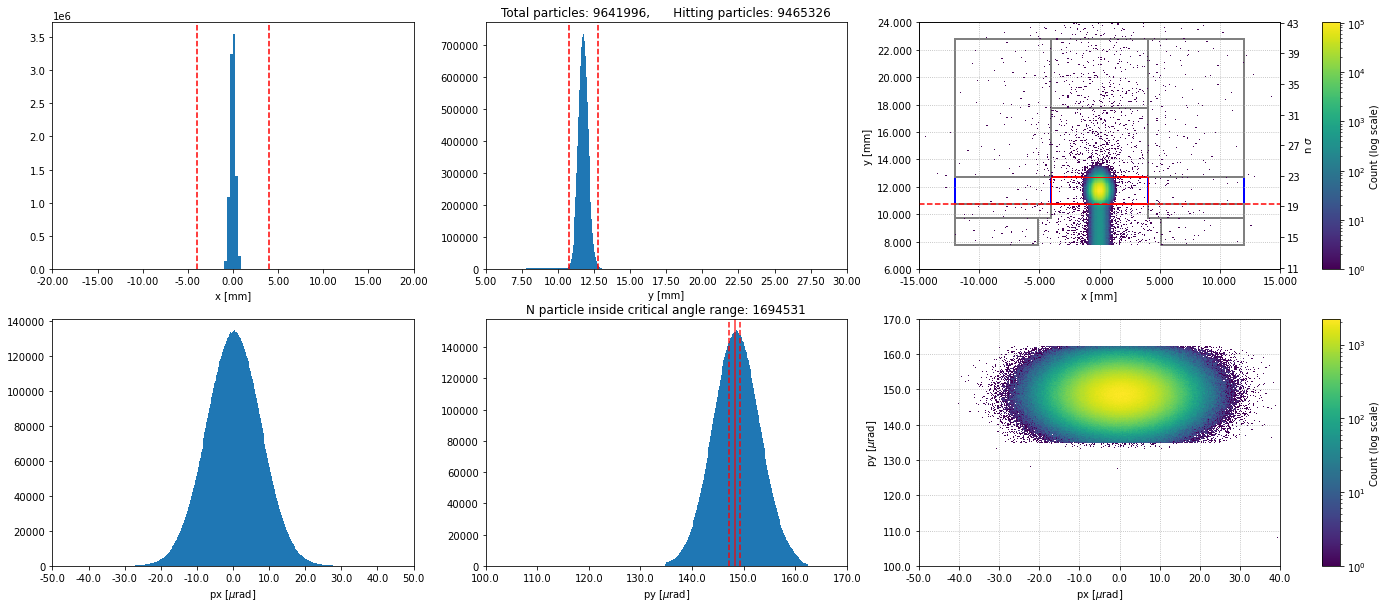

In [58]:
TCCP_TeV3.compute_impact_particles(xpcrit=True, plot_support = True, bins=300)

In [10]:
TCCP_TeV3.TCCP_sim_chann_eff

0.10259759558819362

In [11]:
PIXEL1_TeV3.load_particles(tev3, df_key="PIXEL_impacts_1")

There are repeated particle ids!


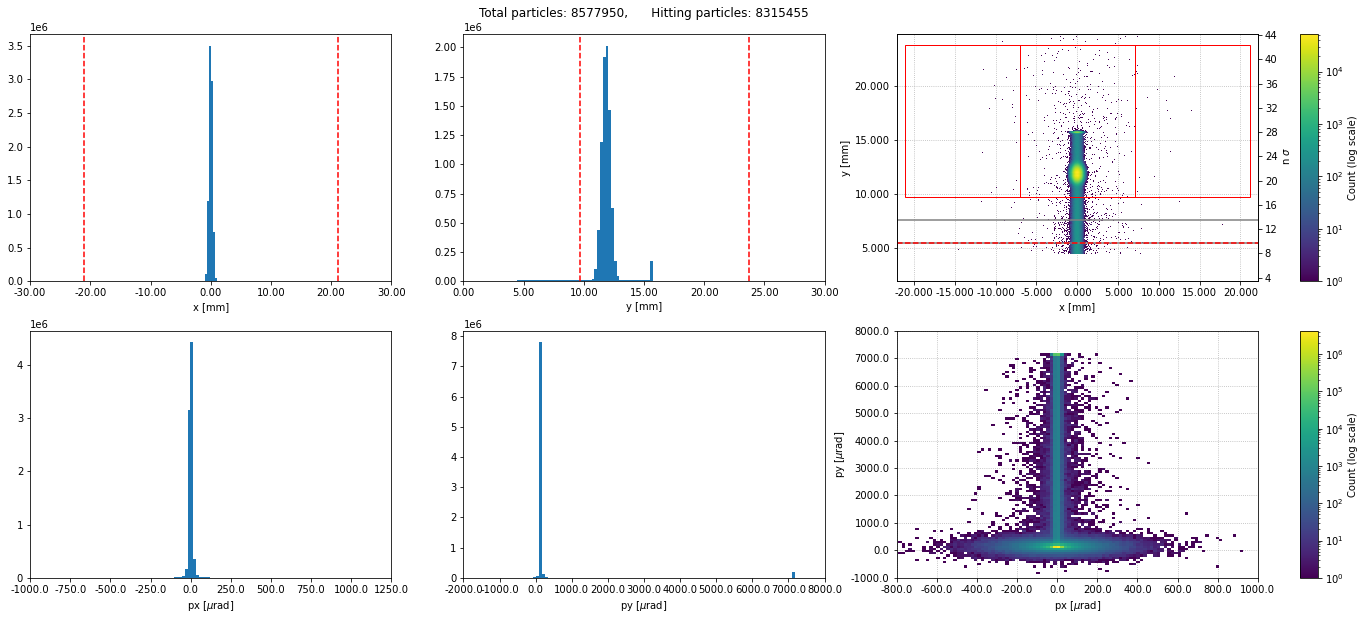

In [12]:
PIXEL1_TeV3.compute_impact_particles()

In [13]:
TFT_TeV3.load_particles(tev3, df_key="TFT_impacts")

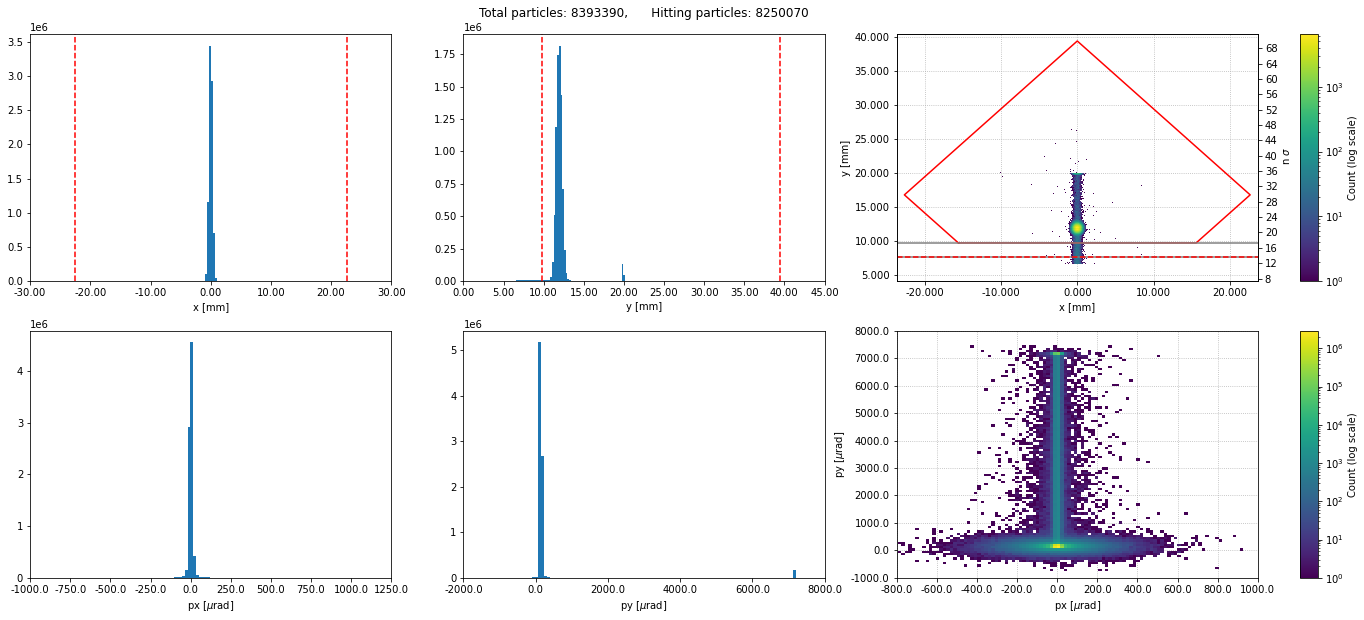

In [14]:
TFT_TeV3.compute_impact_particles()

# local tests

In [137]:
check_hdf_keys('./Outputdata/particles_B2V.h5')

/TCCS_impacts
/TCLA_impacts
/metadata


In [134]:
# 450 GeV DC
TCCS_local = CrystalAnalysis(n_sigma=5.0, length=0.004, ydim=0.002, xdim=0.035,bending_radius=80.0, align_angle=-4.56391e-05, miscut = 0, sigma=0.0013154072397225786, jaw_L=0.006577401104394332)
TCCP_local = CrystalAnalysis(n_sigma=9.4, length=0.07, ydim=0.002, xdim=0.008,bending_radius=10.0, align_angle=0.0001681303, miscut = 0, sigma=0.0014388821741249081, jaw_L=0.013525836359445455)
PIXEL_local = TargetAnalysis(n_sigma=5.5, target_type = 'pixel', ydim=0.01408, xdim=0.04224,sigma=0.001447962320253603)
TFT_local = TargetAnalysis(n_sigma=6.4, target_type='alfa', ydim=0.0297, xdim=0.04525,sigma=0.0014571339362266342)


In [82]:
# 1000 GeV DC
#go_support
TCCS_local = CrystalAnalysis(n_sigma=5.0, length=0.004, ydim=0.002, xdim=0.035,bending_radius=80.0, align_angle=-1.7676e-05, miscut = 0, sigma=0.0005094553484932256, jaw_L=0.0025476310292834683)
TCCP_local =CrystalAnalysis(n_sigma=19.3, length=0.07, ydim=0.002, xdim=0.008,bending_radius=10.0, align_angle=0.0001482704, miscut = 0, sigma=0.0005572767166803468, jaw_L=0.010755775223320323)
PIXEL_local = TargetAnalysis(n_sigma=9.64, target_type = 'pixel', ydim=0.01408, xdim=0.04224,sigma=0.0005607934407635198)
TFT_local = TargetAnalysis(n_sigma=13.48, target_type='alfa', ydim=0.0297, xdim=0.04525,sigma=0.0005643455909511343)



In [ ]:
#3000 GeV
TCCS_local = CrystalAnalysis(n_sigma=5.0, length=0.004, ydim=0.002, xdim=0.035,bending_radius=80.0, align_angle=-1.36917e-05, miscut = 0, sigma=0.0003946224195126737, jaw_L=0.001973466229845415)
TCCP_local = CrystalAnalysis(n_sigma=23.9, length=0.07, ydim=0.002, xdim=0.008,bending_radius=10.0, align_angle=0.0001112712, miscut = 0, sigma=0.0004316646890769982, jaw_L=0.010317120524530946)
PIXEL_local = TargetAnalysis(n_sigma=11.93, target_type = 'pixel', ydim=0.01408, xdim=0.04224,sigma=0.0004343887318228359)
TFT_local = TargetAnalysis(n_sigma=13.48, target_type='alfa', ydim=0.0297, xdim=0.04525,sigma=0.00043714021551102106)


In [128]:
TCCS_local = CrystalAnalysis(n_sigma=5.0, length=0.004, ydim=0.002, xdim=0.035,bending_radius=80.0, align_angle=-4.56391e-05, miscut = 0, sigma=0.0013154072397225786, jaw_L=0.006577401104394332)

In [129]:
TCCS_local.load_particles('', file_name='particles_B2V.h5', Condor = False,
                      default_path = "./Outputdata/", df_key= 'TCCS_impacts', get_absorbed='all')

Error: An unexpected error occurred - 'No object named TCCS_impacts in the file'


In [17]:
TCCS_local.n_TCCS_absorbed

64

In [130]:
TCCS_local.compute_impact_particles(xpcrit=True)

KeyError: 'x'

In [137]:
TCCS_local.channeling_efficiency_sim(half=False)
    

AttributeError: 'NoneType' object has no attribute 'columns'

In [83]:
#go_support
TCCP_local.load_particles('', file_name='particles_B2V.h5', Condor = False,
                      default_path = "./Outputdata/", df_key= 'TCCP_impacts')

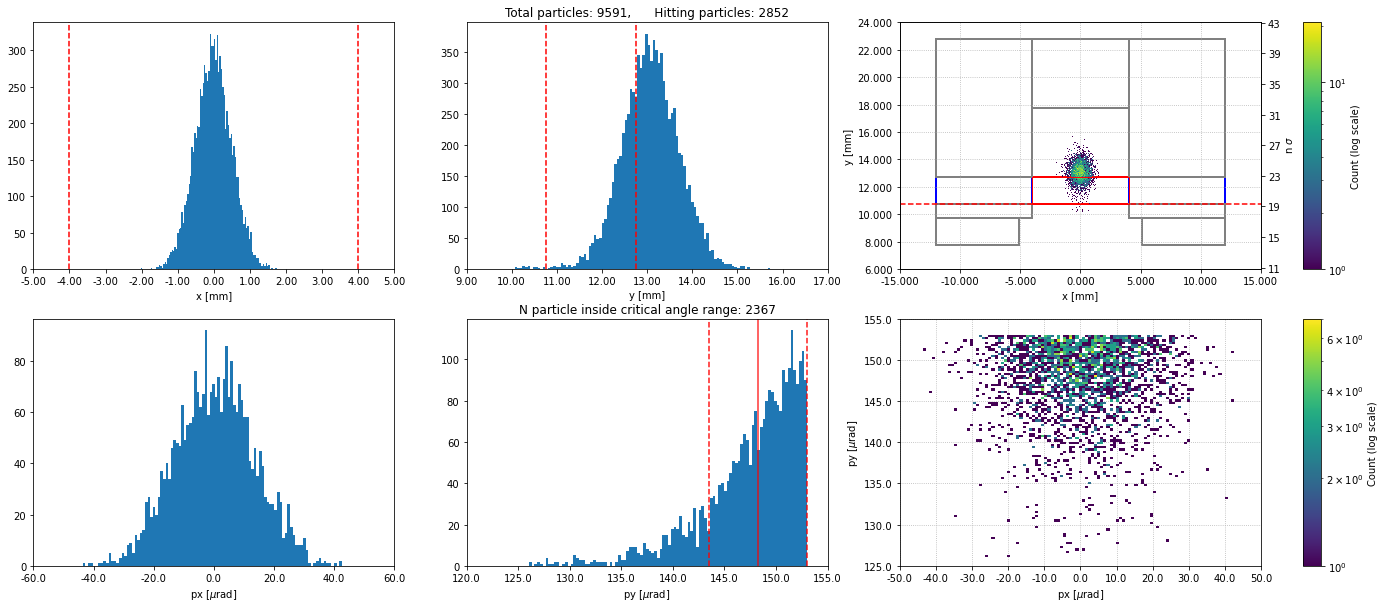

In [84]:
TCCP_local.compute_impact_particles(xpcrit=True, plot_support = True)

In [144]:
TCCP_local.channeling_efficiency_sim(half=False)

No interaction data available --  get through TCCS_sim_chann_eff and TCCP_sim_chann_eff


Delta angle -1.363988381877096e-11


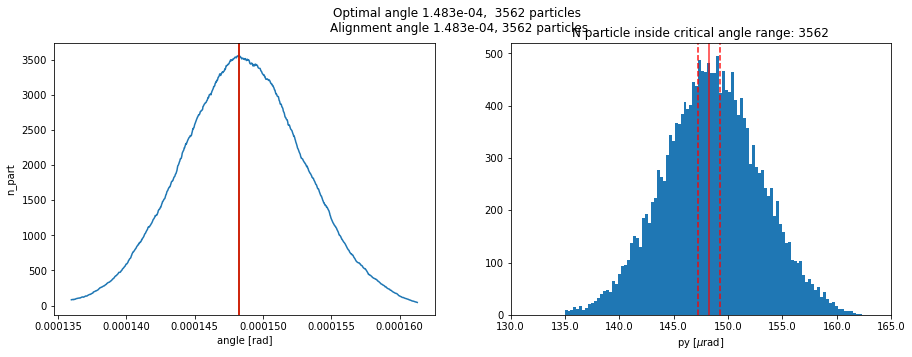

In [45]:
TCCP_local.optimize_alignment()

In [46]:
TCCS_local.count_interactions()

interactions
['CH', 'A']                                                  18
['CH', 'DCH', 'MCS', 'A']                                     5
['CH', 'DCH', 'MCS', 'PN', 'MCS']                             1
['CH', 'DCH', 'MCS', 'PP', 'MCS']                             1
['CH', 'DCH', 'MCS', 'VR', 'MCS', 'A']                        1
['CH', 'DCH', 'MCS', 'VR', 'MCS', 'PN', 'MCS']                2
['CH', 'DCH', 'MCS', 'VR', 'MCS']                           530
['CH', 'DCH', 'MCS']                                        528
['CH', 'PN', 'MCS', 'VR', 'MCS']                              5
['CH', 'PN', 'MCS']                                           4
['CH', 'PP', 'MCS', 'VR', 'MCS']                              1
['CH', 'PP', 'MCS']                                           3
['CH', 'SD', 'MCS']                                           1
['CH']                                                    19055
['MCS', 'A']                                                  1
['MCS', 'VC', 'CH']        

In [47]:
PIXEL_local.load_particles('', file_name='particles_B2V.h5', Condor = False,
                        default_path = "./Outputdata/", df_key= 'PIXEL_impacts_1')


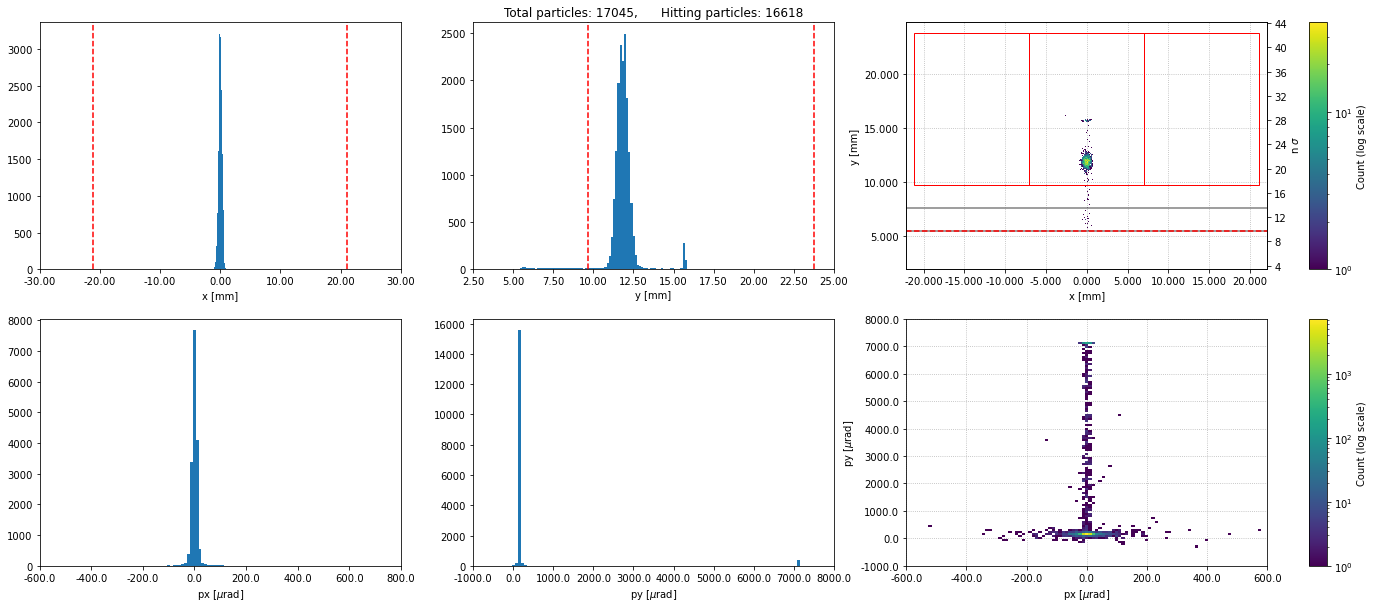

In [48]:
PIXEL_local.compute_impact_particles()

In [49]:
TFT_local.load_particles('', file_name='particles_B2V.h5', Condor = False,
                        default_path = "./Outputdata/", df_key= 'TFT_impacts')

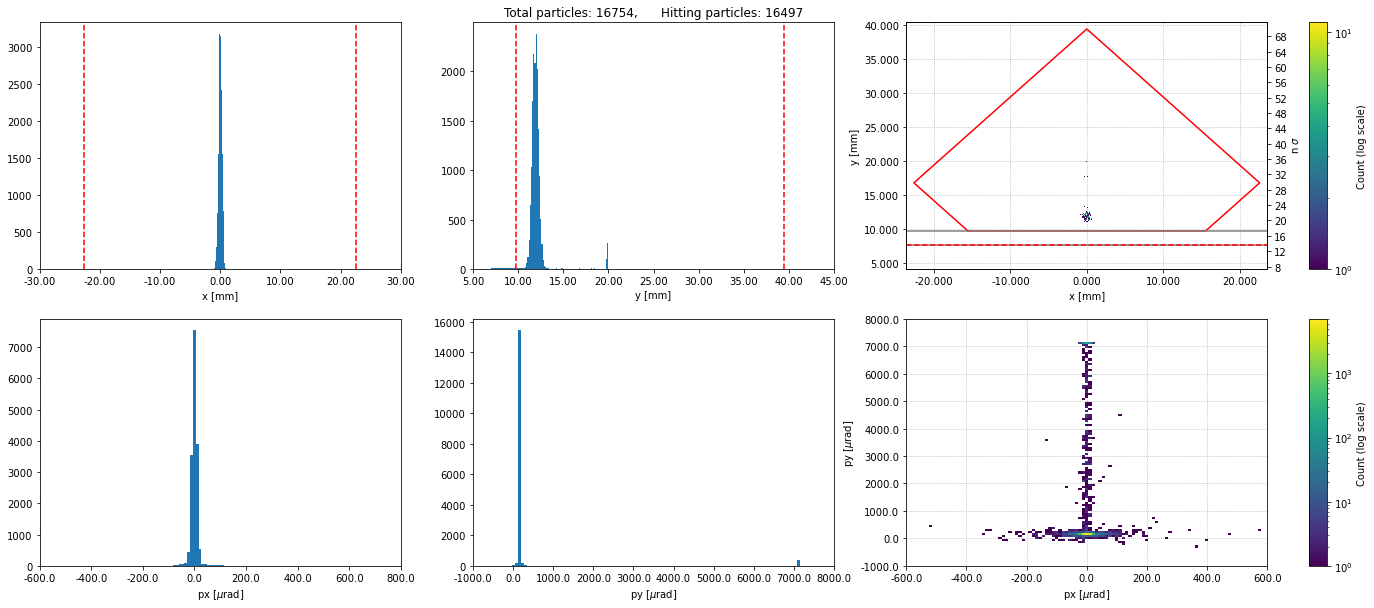

In [50]:
TFT_local.compute_impact_particles()    

#### a


In [167]:
TCCS_loc = CrystalAnalysis(n_sigma=5.0, length=0.004, ydim=0.002, xdim=0.035,bending_radius=80.0, align_angle=-4.56391e-05, miscut = 0, sigma=0.0013154072397225786, jaw_L=0.006577401104394332)
TCLA_loc = TargetAnalysis(n_sigma=5.5, target_type='collimator', length=1, ydim=0.025, xdim=0.025,sigma=0.0011392666165194847,  jaw_L=0.006266181514452619)

In [149]:
TCCS_loc.load_particles('', file_name='particles_B2V.h5', Condor = False,
                        default_path = "./Outputdata/", df_key= 'TCCS_impacts')

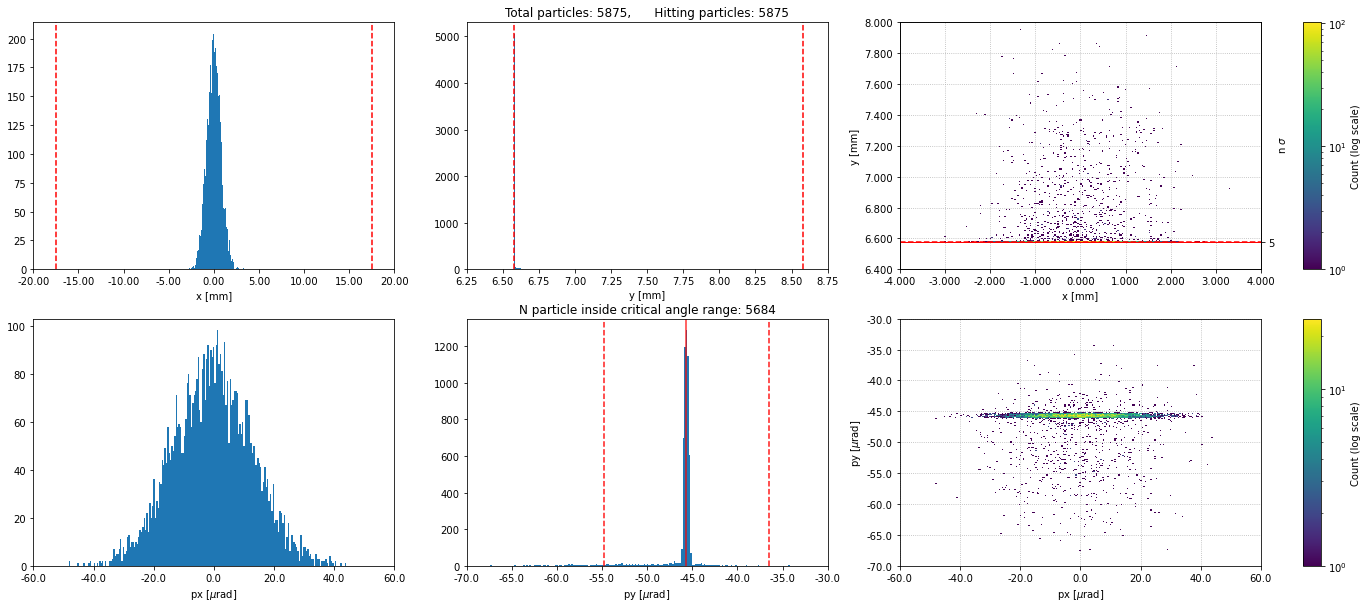

In [150]:
TCCS_loc.compute_impact_particles(xpcrit=True)

In [170]:
TCLA_loc.load_particles('', file_name='particles_B2V.h5', Condor = False,
                        default_path = "./Outputdata/", df_key= 'TCLA_impacts')

There are repeated particle ids!


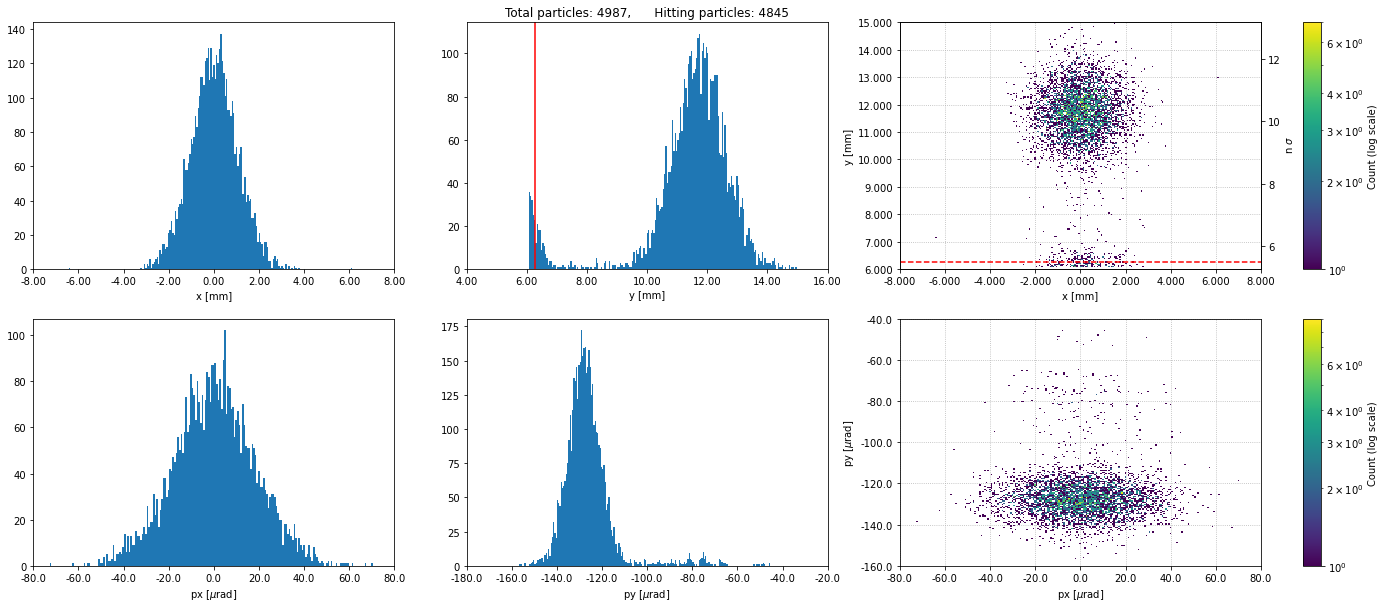

In [163]:
TCLA_loc.compute_impact_particles()

In [153]:
TCLA_loc.twiss_TWOCRYST("./Archive_config_files/config_sim_TCCS_ang_scan_450GeV.yaml")

Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/102068 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102071 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102074 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102077 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102080 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102083 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102086 [00:00<?, ?it/s]

,name,s,x,y,betx,bety,alfx,alfy,mux,muy
26195,tcp.d6r7.b2,6459.742797,-5.631197e-07,-1.700867e-07,148.258907,71.509408,1.906600,-0.960417,15.704216,15.389064
74507,tccs.5r3.b2,19884.940371,3.315562e-06,3.649016e-07,80.226111,237.095916,-0.930386,1.645262,46.202170,44.872507
75043,target.4l3.b2,20005.591371,-2.737339e-06,3.439155e-07,75.721154,283.689144,1.701881,-3.059791,46.322654,45.011595
75046,tccp.4l3.b2,20005.628871,-2.738789e-06,3.440238e-07,75.593585,283.918680,1.699951,-3.061161,46.322733,45.011616
75057,tft.detector,20006.769171,-2.782897e-06,3.473185e-07,71.783568,290.947492,1.641274,-3.102813,46.325197,45.012247
75570,tcla.a5l3.b2,20084.662377,-9.432349e-06,2.132945e-07,142.606240,175.992604,-2.228328,1.856210,46.605216,45.053857


In [154]:
TCLA_loc.get_twiss_for_linear_scan()

(237.0959159975299, 175.9926041648408, -5.143727002921911)

In [159]:
TCLA_loc.get_twiss_for_linear_scan(config_file="./Archive_config_files/config_sim_TCCS_ang_scan_450GeV.yaml")

Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/102068 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102071 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102074 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102077 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102080 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102083 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102086 [00:00<?, ?it/s]

,name,s,x,y,betx,bety,alfx,alfy,mux,muy
26195,tcp.d6r7.b2,6459.742797,-5.631197e-07,-1.700867e-07,148.258907,71.509408,1.906600,-0.960417,15.704216,15.389064
74507,tccs.5r3.b2,19884.940371,3.315562e-06,3.649016e-07,80.226111,237.095916,-0.930386,1.645262,46.202170,44.872507
75043,target.4l3.b2,20005.591371,-2.737339e-06,3.439155e-07,75.721154,283.689144,1.701881,-3.059791,46.322654,45.011595
75046,tccp.4l3.b2,20005.628871,-2.738789e-06,3.440238e-07,75.593585,283.918680,1.699951,-3.061161,46.322733,45.011616
75057,tft.detector,20006.769171,-2.782897e-06,3.473185e-07,71.783568,290.947492,1.641274,-3.102813,46.325197,45.012247
75570,tcla.a5l3.b2,20084.662377,-9.432349e-06,2.132945e-07,142.606240,175.992604,-2.228328,1.856210,46.605216,45.053857


(237.0959159975299, 175.9926041648408, -5.143727002921911)

Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/102068 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102071 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102074 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102077 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102080 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102083 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102086 [00:00<?, ?it/s]

,name,s,x,y,betx,bety,alfx,alfy,mux,muy
26195,tcp.d6r7.b2,6459.742797,-5.631197e-07,-1.700867e-07,148.258907,71.509408,1.906600,-0.960417,15.704216,15.389064
74507,tccs.5r3.b2,19884.940371,3.315562e-06,3.649016e-07,80.226111,237.095916,-0.930386,1.645262,46.202170,44.872507
75043,target.4l3.b2,20005.591371,-2.737339e-06,3.439155e-07,75.721154,283.689144,1.701881,-3.059791,46.322654,45.011595
75046,tccp.4l3.b2,20005.628871,-2.738789e-06,3.440238e-07,75.593585,283.918680,1.699951,-3.061161,46.322733,45.011616
75057,tft.detector,20006.769171,-2.782897e-06,3.473185e-07,71.783568,290.947492,1.641274,-3.102813,46.325197,45.012247
75570,tcla.a5l3.b2,20084.662377,-9.432349e-06,2.132945e-07,142.606240,175.992604,-2.228328,1.856210,46.605216,45.053857


Height:  0.9554921840612769  a.u.
Mean:  0.011735794216692408  mm
Sigma:  0.0008499749878641109  mm
Calculated theta [urad]:  49.022
Efficiency:  95.55 %


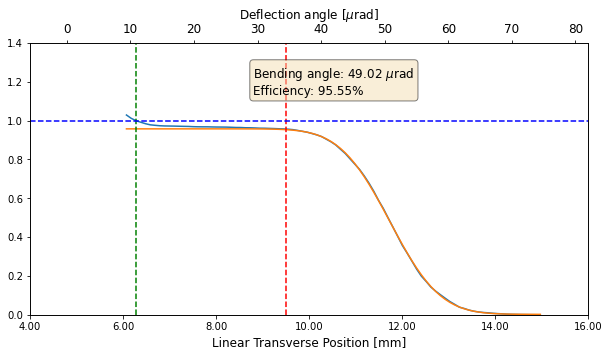

In [165]:
TCLA_loc.linear_scan(PosEnvelope=None, PosMaxErfFit= 9.5e-3, param0=[0.5, -1, 10e-3, 0.0002], config_file="./Archive_config_files/config_sim_TCCS_ang_scan_450GeV.yaml")

Height:  0.9879267033147773  a.u.
Mean:  0.011735794212678166  mm
Sigma:  0.0008499750072408743  mm
Calculated theta [urad]:  39.679
Efficiency:  98.79 %


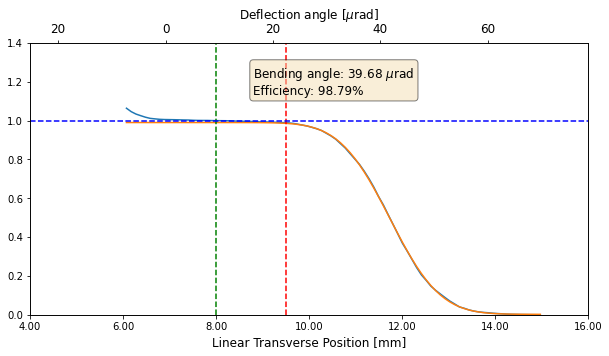

In [166]:
TCLA_loc.linear_scan(PosEnvelope=8e-3, PosMaxErfFit= 9.5e-3, param0=[0.5, -1, 10e-3, 0.0002])

Height:  0.9554921840612769  a.u.
Mean:  0.011735794216692408  mm
Sigma:  0.0008499749878641109  mm
Calculated theta [urad]:  48.845
Efficiency:  95.55 %


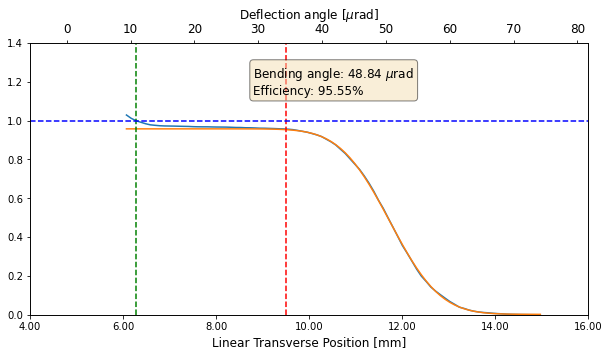

In [171]:
TCLA_loc.linear_scan(PosEnvelope=None, PosMaxErfFit= 9.5e-3, param0=[0.5, -1, 10e-3, 0.0002], beta_COLL=beta_TCLA, beta_CRY=beta_TCCS, deltaphi_CRY_COLL=dphi_TCCS_TCLA)

In [173]:
TCLA_loc.get_twiss_for_linear_scan(config_file="./Archive_config_files/config_sim_TCCS_ang_scan_450GeV.yaml", CRY_name=TCCP_name, COLL_name=TCLA_name)

Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           


Slicing line:   0%|          | 0/102068 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102071 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102074 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102077 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102080 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102083 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102086 [00:00<?, ?it/s]

,name,s,x,y,betx,bety,alfx,alfy,mux,muy
26195,tcp.d6r7.b2,6459.742797,-5.631197e-07,-1.700867e-07,148.258907,71.509408,1.906600,-0.960417,15.704216,15.389064
74507,tccs.5r3.b2,19884.940371,3.315562e-06,3.649016e-07,80.226111,237.095916,-0.930386,1.645262,46.202170,44.872507
75043,target.4l3.b2,20005.591371,-2.737339e-06,3.439155e-07,75.721154,283.689144,1.701881,-3.059791,46.322654,45.011595
75046,tccp.4l3.b2,20005.628871,-2.738789e-06,3.440238e-07,75.593585,283.918680,1.699951,-3.061161,46.322733,45.011616
75057,tft.detector,20006.769171,-2.782897e-06,3.473185e-07,71.783568,290.947492,1.641274,-3.102813,46.325197,45.012247
75570,tcla.a5l3.b2,20084.662377,-9.432349e-06,2.132945e-07,142.606240,175.992604,-2.228328,1.856210,46.605216,45.053857


(283.91868033289614, 175.9926041648408, 0.2654132061962745)

Height:  0.9879267033147773  a.u.
Mean:  0.011735794212678166  mm
Sigma:  0.0008499750072408743  mm
Calculated theta [urad]:  3276.19
Efficiency:  98.79 %


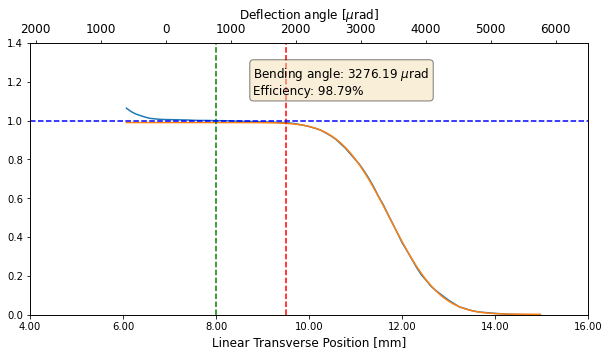

In [175]:
TCLA_loc.linear_scan(PosEnvelope=8e-3, PosMaxErfFit= 9.5e-3, param0=[0.5, -1, 10e-3, 0.0002], CRY_name=TCCP_name, COLL_name=TFT_name)